# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [69]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [70]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')


### Data Cleaning
#### 1. Data Cleaning - convert unknown values to `NaN`
The first step is to look at the features and the range of possible of each range. The description of each column can be found in `DIAS Information Levels - Attributes 2017.xlsx` and `DIAS Attributes - Values 2017.xlsx`. The values of each feature contains different ranges, and some represents "unknown". The first step is to manually convert these "unknowns" to NaN.


##### a) read features from attribute file

In [71]:
# Read attribute file from xlsx
ATTRIBUTE_FILE="DIAS Attributes - Values 2017.xlsx"
df_Levels_Attributes = pd.read_excel(ATTRIBUTE_FILE)

# This step can fill the attribute names in the consecutive rows.
for i in range(len(df_Levels_Attributes["Attribute"])):
    if pd.isna(df_Levels_Attributes.iloc[i]["Attribute"]):
        df_Levels_Attributes.at[i,"Attribute"] = attr_name
    else:
        attr_name = df_Levels_Attributes.iloc[i]["Attribute"]

# Parse the attribute file to get values representing "unknown"
COLUMN_UNKNOWN_VALUE = dict()
for index, row in df_Levels_Attributes[df_Levels_Attributes["Meaning"] == "unknown"].iterrows():
    COLUMN_UNKNOWN_VALUE[row["Attribute"]] = [int(n) for n in str(row["Value"]).split(",")]

# These are the columns for integer. So the value would be "..."
INTEGER_LABELS_COLUMN = {"ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", 
                         "ANZ_TITEL", "GEBURTSJAHR", "KBA13_ANZAHL_PKW", "MIN_GEBAEUDEJAHR", "LNR"}

# Construct the unknown and acceptable values for each column.
COLUMN_LABELS = dict()
for index, row in df_Levels_Attributes[df_Levels_Attributes["Meaning"] != "unknown"].iterrows():
    if row["Attribute"] not in COLUMN_LABELS:
        COLUMN_LABELS[row["Attribute"]] = []
    if row["Attribute"] in INTEGER_LABELS_COLUMN:
        continue
    COLUMN_LABELS[row["Attribute"]] += str(row["Value"]).split(",")

# Check the difference columns in two datasets
print(set(customers.columns) - set(azdias.columns))

set(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'])


##### b) Drop undocumented features
Many features in the azdias and customers dataframe are not explained in the attribute file. These columns are kept.

In [72]:
# Print the missing undocumented features
UNDOCUMENTED_COLUMN = set(azdias.columns) - set(COLUMN_LABELS.keys())
print(UNDOCUMENTED_COLUMN)

# LNR should be sequence number of samples. Dropped from data frames
#azdias = azdias.drop(columns={"LNR"})
#customers = customers.drop(columns={"LNR"})


set(['CJT_TYP_6', 'CJT_TYP_5', 'CJT_TYP_4', 'CJT_TYP_3', 'CJT_TYP_2', 'CJT_TYP_1', 'UMFELD_JUNG', 'D19_TELKO_REST', 'D19_NAHRUNGSERGAENZUNG', 'ANZ_KINDER', 'EINGEFUEGT_AM', 'D19_SAMMELARTIKEL', 'RT_KEIN_ANREIZ', 'KONSUMZELLE', 'D19_KONSUMTYP_MAX', 'CJT_KATALOGNUTZER', 'D19_BANKEN_LOKAL', 'DSL_FLAG', 'D19_KINDERARTIKEL', 'ALTERSKATEGORIE_FEIN', 'KBA13_HHZ', 'STRUKTURTYP', 'D19_KOSMETIK', 'D19_RATGEBER', 'UNGLEICHENN_FLAG', 'RT_UEBERGROESSE', 'D19_BILDUNG', 'EXTSEL992', 'D19_DROGERIEARTIKEL', 'EINGEZOGENAM_HH_JAHR', 'D19_DIGIT_SERV', 'ARBEIT', 'D19_TELKO_ONLINE_QUOTE_12', 'VK_DHT4A', 'D19_VERSI_ONLINE_QUOTE_12', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_BAUMAX', 'D19_VOLLSORTIMENT', 'KBA13_KMH_210', 'D19_BEKLEIDUNG_REST', 'D19_VERSICHERUNGEN', 'D19_VERSI_OFFLINE_DATUM', 'D19_SCHUHE', 'D19_BEKLEIDUNG_GEH', 'D19_VERSAND_REST', 'D19_TELKO_MOBILE', 'LNR', 'D19_TIERARTIKEL', 'D19_BANKEN_REST', 'D19_VERSI_ONLINE_DATUM', 'D19_HAUS_DEKO', 'VK_ZG11', 'KOMBIALTER', 'D19_LEBENSMITTEL', 'D19_HANDWERK',

##### c) Convert values that represents "unknown" to `NaN`
In some columns, the value of `0` or `-1` actually means unknown,or some values are out-of-range. These data are replaced with `NaN`.

In [73]:
# Fill the unknown values with NaN
def fill_unknown_values(df):
    MISSING_COLUMN = set(COLUMN_LABELS.keys()) - set(df.columns)
    for column_name in COLUMN_LABELS:
        # Skip undocumneted columns
        if column_name in MISSING_COLUMN:
            continue
            
        # Skip integer columns
        if column_name in INTEGER_LABELS_COLUMN:
            continue
        
        # Find the out-of-range value and unknown values
        nan_mask = ~df[column_name].isin(COLUMN_LABELS[column_name])
        if column_name in COLUMN_UNKNOWN_VALUE:
            nan_mask |= df[column_name].isin(COLUMN_UNKNOWN_VALUE[column_name])
        # Fill nan
        df.loc[nan_mask, column_name] = np.nan

    # special handling
    df.loc[df["GEBURTSJAHR"] == 0, "GEBURTSJAHR"] = np.nan


fill_unknown_values(azdias)
fill_unknown_values(customers)


##### d) Handle numerical strings

In [74]:
# Convert the numerica strings to int
def convert_str_to_int(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')

convert_str_to_int(azdias, "CAMEO_DEUG_2015")
convert_str_to_int(azdias, "CAMEO_INTL_2015")
convert_str_to_int(customers, "CAMEO_DEUG_2015")
convert_str_to_int(customers, "CAMEO_INTL_2015")

# convert the time stamp to number of days after 1900-01-01
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM']).sub(pd.Timestamp('1900-01-01')).dt.days
customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM']).sub(pd.Timestamp('1900-01-01')).dt.days

##### e) Check the percetage of NaN values in each column
The majority of NaN is less than 0.15% and at most 0.40% of total features in both of dataset, so it would not have significant impact on the results. 

Text(0.5,1,'Histogram')

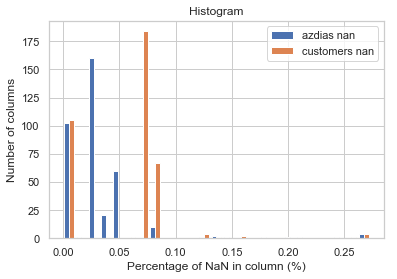

In [75]:
# Summation over all the nan samples in each column
azdias_nan_counter = {column_name: np.sum(azdias[column_name].isna()) for column_name in azdias.columns}
customers_nan_counter = {column_name: np.sum(customers[column_name].isna()) for column_name in customers.columns}

# Compute the percentage
azdias_na_percent = [100.0*v/float(azdias.size) for v in azdias_nan_counter.values()]
customers_na_percent = [100.0*v/float(customers.size) for v in customers_nan_counter.values()]

plt.hist([azdias_na_percent, customers_na_percent], bins = 25, label=["azdias nan", "customers nan"])

# Plot formatting
plt.legend()
plt.xlabel('Percentage of NaN in column (%)')
plt.ylabel('Number of columns')
plt.title('Histogram')

#### Data Cleaning - Handling catagorized values

In [76]:
# Convert data of two categories to 0, 1
def convert_biclass_to_int(df, column):
    nan_mask = df[column].notna()
    df.loc[nan_mask, column] = df[column][nan_mask].astype('category').cat.codes

convert_biclass_to_int(azdias, "OST_WEST_KZ")
convert_biclass_to_int(customers, "OST_WEST_KZ")
print(azdias.groupby("OST_WEST_KZ").groups.keys())
print(customers.groupby("OST_WEST_KZ").groups.keys())

[0, 1]
[0, 1]


In [77]:
# Convert data of two categories to one-hot-encoding
def convert_categories_to_onehot(df, column):
    nan_mask = df[column].notna()
    df.loc[nan_mask, column] = df[column][nan_mask].astype('category')
    
    # Get one-hot encoding
    onehot = pd.get_dummies(df[column], prefix=column, dummy_na=True)
    df = pd.concat([df, onehot], axis=1)
    
    # drop the original column
    df = df.drop(columns=[column])

    return df

azdias = convert_categories_to_onehot(azdias, "CAMEO_DEU_2015")
customers = convert_categories_to_onehot(customers, "CAMEO_DEU_2015")
azdias = convert_categories_to_onehot(azdias, "D19_LETZTER_KAUF_BRANCHE")
customers = convert_categories_to_onehot(customers, "D19_LETZTER_KAUF_BRANCHE")

In [78]:
# Print groups in each column to double check all the features are within range.
def print_groups(df):
    for column_name in df.columns:
        keys = df.groupby(column_name).groups.keys()

        # Skip the columns which has numbers from 0~24 to reduce the printing
        if set(keys) <= set(range(25)):
            continue
        print("***** {} *****".format(column_name))
        print(keys)


print_groups(azdias)
print_groups(customers)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



***** ANZ_HAUSHALTE_AKTIV *****
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0,

***** GEBURTSJAHR *****
[1900.0, 1902.0, 1904.0, 1905.0, 1906.0, 1907.0, 1908.0, 1909.0, 1910.0, 1911.0, 1912.0, 1913.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0]
***** GEMEINDETYP *****
[40.0, 11.0, 12.0, 50.0

***** LP_LEBENSPHASE_FEIN *****
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
***** MIN_GEBAEUDEJAHR *****
[1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]
***** VERDICHTUNGSRAUM *****
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0]
***** LNR *****
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37

***** EINGEFUEGT_AM *****
[40966.0, 40971.0, 40984.0, 40995.0, 41007.0, 41016.0, 41030.0, 41034.0, 41037.0, 41045.0, 41049.0, 41051.0, 41056.0, 41058.0, 41059.0, 41063.0, 41069.0, 41072.0, 41085.0, 41092.0, 41098.0, 41106.0, 41107.0, 41113.0, 41115.0, 41116.0, 41118.0, 41120.0, 41121.0, 41122.0, 41126.0, 41128.0, 41132.0, 41139.0, 41143.0, 41149.0, 41155.0, 41162.0, 41163.0, 41164.0, 41169.0, 41175.0, 41184.0, 41185.0, 41186.0, 41191.0, 41192.0, 41199.0, 41209.0, 41211.0, 41218.0, 41219.0, 41224.0, 41225.0, 41232.0, 41233.0, 41237.0, 41239.0, 41245.0, 41246.0, 41252.0, 41254.0, 41258.0, 41274.0, 41275.0, 41282.0, 41287.0, 41288.0, 41295.0, 41304.0, 41307.0, 41321.0, 41325.0, 41330.0, 41335.0, 41339.0, 41343.0, 41344.0, 41350.0, 41358.0, 41365.0, 41371.0, 41384.0, 41387.0, 41391.0, 41392.0, 41394.0, 41398.0, 41407.0, 41413.0, 41414.0, 41421.0, 41427.0, 41429.0, 41430.0, 41440.0, 41444.0, 41449.0, 41450.0, 41451.0, 41455.0, 41457.0, 41463.0, 41471.0, 41479.0, 41482.0, 41483.0, 41486.0, 4

***** KBA13_ANZAHL_PKW *****
[5.0, 6.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0

***** LP_LEBENSPHASE_FEIN *****
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
***** MIN_GEBAEUDEJAHR *****
[1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]
***** VERDICHTUNGSRAUM *****
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0]
***** PRODUCT_GROUP *****
['FOOD', 'COSMETIC', 'COSMETIC_AND_FOOD']
***** CUSTOMER_GROUP *****
['MULTI_BUYER', 'SINGLE_BUYER']


#### Data Cleaning - Use mean instead of `Nan`

In [79]:
columns = list(customers.columns)
columns.remove("CUSTOMER_GROUP")
columns.remove("ONLINE_PURCHASE")
columns.remove("PRODUCT_GROUP")

# Replace NaN with means 
for c in columns:
    customers[c].fillna(customers[c].mean(), inplace=True)
    azdias[c].fillna(azdias[c].mean(), inplace=True)

# Double check if all the NaN are removed.
print([col for col in customers.columns if np.sum(customers[col].isna()) > 0])
print([col for col in azdias.columns if np.sum(azdias[col].isna()) > 0])


[]
[]


In [80]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_nan
count,8.912210e+05,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,1.675376,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,0.007857,0.016210,0.012872,0.002893,0.219180,0.029212,0.064781,0.039061,0.002428,0.288495
std,2.572735e+05,0.363477,3.485531,7.317883,1.235773,0.590053,0.225670,0.090158,4.265133,14.788850,...,0.088289,0.126284,0.112723,0.053706,0.413691,0.168399,0.246139,0.193740,0.049216,0.453063
min,1.916530e+05,0.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.144580e+05,1.675376,1.000000,0.000000,11.745392,13.402658,14.476013,15.089627,13.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.372630e+05,1.675376,4.000000,12.000000,11.745392,13.402658,14.476013,15.089627,13.700717,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.600680e+05,1.675376,9.000000,17.000000,11.745392,13.402658,14.476013,15.089627,16.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1. Normalize data

In [81]:
# Normalization with mean-std. This was the original step, but didn't work well.
#mean_azdias = azdias.mean()
#std_azdias = azdias.std()
#normalized_azdias = (azdias - mean_azdias)/std_azdias

# Normalization with min-max
max_azdias = azdias.max()
min_azdias = azdias.min()
normalized_azdias = (azdias - min_azdias)/(max_azdias - min_azdias)
normalized_azdias.describe()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_nan
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,0.500000,0.558459,0.427741,0.517339,0.609087,0.712666,0.748287,0.735421,0.548029,0.013928,...,0.007857,0.016210,0.012872,0.002893,0.219180,0.029212,0.064781,0.039061,0.002428,0.288495
std,0.288676,0.121159,0.435691,0.348471,0.077236,0.036878,0.016119,0.008196,0.170605,0.024855,...,0.088289,0.126284,0.112723,0.053706,0.413691,0.168399,0.246139,0.193740,0.049216,0.453063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.558459,0.000000,0.000000,0.609087,0.712666,0.748287,0.735421,0.520000,0.003361,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.558459,0.375000,0.571429,0.609087,0.712666,0.748287,0.735421,0.548029,0.008403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750000,0.558459,1.000000,0.809524,0.609087,0.712666,0.748287,0.735421,0.640000,0.015126,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. PCA

Text(0,0.5,'Cumulative Power Ratio')

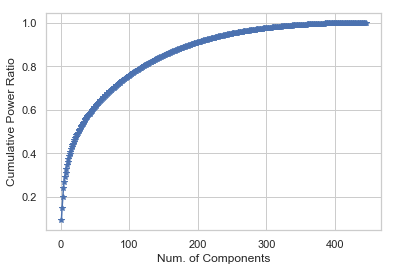

In [82]:
# Principle Component Analysis
from sklearn.decomposition import PCA
pca = PCA()
azdias_rotated = pca.fit_transform(normalized_azdias)
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")
plt.xlabel("Num. of Components")
plt.ylabel("Cumulative Power Ratio")

The first 150 componants accommodate 90% of energy. However, there is no significant transition in the energy. So we can use the entire feature sets for now.

### 3. K-Means Clustering

#### The elbow is around 260 clusters.

In [15]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

print(normalized_azdias.shape)

inertias_mini = []

ks = range(10,501,10)
for k in ks:
    # execute the K-Means on the range. Append results to inertias_mini
    print("**** {} ****".format(k))
    kmeans = MiniBatchKMeans(n_clusters=k, verbose=0)
    kmeans.fit(normalized_azdias.values)
    inertias_mini.append(kmeans.inertia_)


(891221, 444)
**** 10 ****
**** 20 ****
**** 30 ****
**** 40 ****
**** 50 ****


Text(0,0.5,'Inertia')

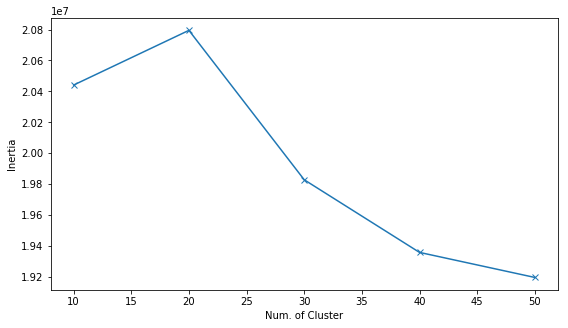

In [16]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,2,1)
plt.plot(ks,inertias_mini,marker='x')# want to use elbow method to find best k

plt.xlabel("Num. of Cluster")
plt.ylabel("Inertia")

#### The elbow is around 240, the kmeans is re-trained and predicts.

In [17]:
kmeans = MiniBatchKMeans(n_clusters=240, verbose=1)
kmeans.fit(normalized_azdias.values)

Init 1/3 with method: k-means++
Inertia for init 1/3: 5221.989604
Init 2/3 with method: k-means++
Inertia for init 2/3: 5270.990445
Init 3/3 with method: k-means++
Inertia for init 3/3: 5365.747706
Minibatch iteration 1/891300: mean batch inertia: 24.293710, ewa inertia: 24.293710 
Minibatch iteration 2/891300: mean batch inertia: 23.092887, ewa inertia: 24.293440 
Minibatch iteration 3/891300: mean batch inertia: 23.432620, ewa inertia: 24.293247 
Minibatch iteration 4/891300: mean batch inertia: 24.170849, ewa inertia: 24.293219 
Minibatch iteration 5/891300: mean batch inertia: 23.435634, ewa inertia: 24.293027 
Minibatch iteration 6/891300: mean batch inertia: 23.618767, ewa inertia: 24.292876 
Minibatch iteration 7/891300: mean batch inertia: 23.782066, ewa inertia: 24.292761 
Minibatch iteration 8/891300: mean batch inertia: 23.432235, ewa inertia: 24.292568 
Minibatch iteration 9/891300: mean batch inertia: 22.170713, ewa inertia: 24.292092 
[MiniBatchKMeans] Reassigning 50 clus

Minibatch iteration 144/891300: mean batch inertia: 19.700735, ewa inertia: 24.221284 
Minibatch iteration 145/891300: mean batch inertia: 21.325973, ewa inertia: 24.220634 
Minibatch iteration 146/891300: mean batch inertia: 20.781096, ewa inertia: 24.219862 
Minibatch iteration 147/891300: mean batch inertia: 20.242354, ewa inertia: 24.218969 
Minibatch iteration 148/891300: mean batch inertia: 21.415536, ewa inertia: 24.218340 
Minibatch iteration 149/891300: mean batch inertia: 22.391715, ewa inertia: 24.217930 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 150/891300: mean batch inertia: 22.353492, ewa inertia: 24.217512 
Minibatch iteration 151/891300: mean batch inertia: 21.385559, ewa inertia: 24.216877 
Minibatch iteration 152/891300: mean batch inertia: 22.320480, ewa inertia: 24.216451 
Minibatch iteration 153/891300: mean batch inertia: 22.104758, ewa inertia: 24.215977 
Minibatch iteration 154/891300: mean batch inertia: 20.967585, ewa inertia: 24.2

Minibatch iteration 283/891300: mean batch inertia: 21.769502, ewa inertia: 24.133183 
Minibatch iteration 284/891300: mean batch inertia: 21.266337, ewa inertia: 24.132539 
Minibatch iteration 285/891300: mean batch inertia: 20.808972, ewa inertia: 24.131794 
Minibatch iteration 286/891300: mean batch inertia: 21.687868, ewa inertia: 24.131245 
Minibatch iteration 287/891300: mean batch inertia: 21.251973, ewa inertia: 24.130599 
Minibatch iteration 288/891300: mean batch inertia: 21.356765, ewa inertia: 24.129976 
Minibatch iteration 289/891300: mean batch inertia: 19.578329, ewa inertia: 24.128955 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 290/891300: mean batch inertia: 20.800147, ewa inertia: 24.128208 
Minibatch iteration 291/891300: mean batch inertia: 22.680780, ewa inertia: 24.127883 
Minibatch iteration 292/891300: mean batch inertia: 21.261328, ewa inertia: 24.127240 
Minibatch iteration 293/891300: mean batch inertia: 21.607148, ewa inertia: 24.1

Minibatch iteration 414/891300: mean batch inertia: 21.262431, ewa inertia: 24.043243 
Minibatch iteration 415/891300: mean batch inertia: 22.349167, ewa inertia: 24.042862 
Minibatch iteration 416/891300: mean batch inertia: 21.042222, ewa inertia: 24.042189 
Minibatch iteration 417/891300: mean batch inertia: 22.406879, ewa inertia: 24.041822 
Minibatch iteration 418/891300: mean batch inertia: 20.188420, ewa inertia: 24.040957 
Minibatch iteration 419/891300: mean batch inertia: 20.929694, ewa inertia: 24.040259 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 420/891300: mean batch inertia: 21.308968, ewa inertia: 24.039646 
Minibatch iteration 421/891300: mean batch inertia: 20.857953, ewa inertia: 24.038932 
Minibatch iteration 422/891300: mean batch inertia: 21.673270, ewa inertia: 24.038401 
Minibatch iteration 423/891300: mean batch inertia: 21.867213, ewa inertia: 24.037914 
Minibatch iteration 424/891300: mean batch inertia: 21.578842, ewa inertia: 24.0

Minibatch iteration 543/891300: mean batch inertia: 21.188651, ewa inertia: 23.951671 
Minibatch iteration 544/891300: mean batch inertia: 19.609356, ewa inertia: 23.950696 
Minibatch iteration 545/891300: mean batch inertia: 22.888848, ewa inertia: 23.950458 
Minibatch iteration 546/891300: mean batch inertia: 21.568899, ewa inertia: 23.949924 
Minibatch iteration 547/891300: mean batch inertia: 21.133492, ewa inertia: 23.949291 
Minibatch iteration 548/891300: mean batch inertia: 21.032962, ewa inertia: 23.948637 
Minibatch iteration 549/891300: mean batch inertia: 20.354305, ewa inertia: 23.947830 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 550/891300: mean batch inertia: 20.939590, ewa inertia: 23.947155 
Minibatch iteration 551/891300: mean batch inertia: 19.626342, ewa inertia: 23.946186 
Minibatch iteration 552/891300: mean batch inertia: 21.068707, ewa inertia: 23.945540 
Minibatch iteration 553/891300: mean batch inertia: 20.070992, ewa inertia: 23.9

Minibatch iteration 669/891300: mean batch inertia: 20.943746, ewa inertia: 23.859462 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 670/891300: mean batch inertia: 19.316944, ewa inertia: 23.858442 
Minibatch iteration 671/891300: mean batch inertia: 21.186861, ewa inertia: 23.857843 
Minibatch iteration 672/891300: mean batch inertia: 20.126258, ewa inertia: 23.857005 
Minibatch iteration 673/891300: mean batch inertia: 20.343826, ewa inertia: 23.856217 
Minibatch iteration 674/891300: mean batch inertia: 20.912830, ewa inertia: 23.855556 
Minibatch iteration 675/891300: mean batch inertia: 20.538060, ewa inertia: 23.854812 
Minibatch iteration 676/891300: mean batch inertia: 20.184573, ewa inertia: 23.853988 
Minibatch iteration 677/891300: mean batch inertia: 21.547025, ewa inertia: 23.853471 
Minibatch iteration 678/891300: mean batch inertia: 20.325462, ewa inertia: 23.852679 
Minibatch iteration 679/891300: mean batch inertia: 21.001222, ewa inertia: 23.8

Minibatch iteration 793/891300: mean batch inertia: 21.183748, ewa inertia: 23.767354 
Minibatch iteration 794/891300: mean batch inertia: 20.722066, ewa inertia: 23.766671 
Minibatch iteration 795/891300: mean batch inertia: 20.178868, ewa inertia: 23.765865 
Minibatch iteration 796/891300: mean batch inertia: 21.035999, ewa inertia: 23.765253 
Minibatch iteration 797/891300: mean batch inertia: 20.991059, ewa inertia: 23.764630 
Minibatch iteration 798/891300: mean batch inertia: 21.594017, ewa inertia: 23.764143 
Minibatch iteration 799/891300: mean batch inertia: 20.967832, ewa inertia: 23.763516 
Minibatch iteration 800/891300: mean batch inertia: 20.069000, ewa inertia: 23.762687 
Minibatch iteration 801/891300: mean batch inertia: 20.658792, ewa inertia: 23.761990 
Minibatch iteration 802/891300: mean batch inertia: 21.066330, ewa inertia: 23.761385 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 803/891300: mean batch inertia: 20.978170, ewa inertia: 23.7

Minibatch iteration 918/891300: mean batch inertia: 19.838898, ewa inertia: 23.678893 
Minibatch iteration 919/891300: mean batch inertia: 21.152008, ewa inertia: 23.678326 
Minibatch iteration 920/891300: mean batch inertia: 21.229126, ewa inertia: 23.677777 
Minibatch iteration 921/891300: mean batch inertia: 19.932083, ewa inertia: 23.676936 
Minibatch iteration 922/891300: mean batch inertia: 20.220182, ewa inertia: 23.676160 
Minibatch iteration 923/891300: mean batch inertia: 20.421428, ewa inertia: 23.675430 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 924/891300: mean batch inertia: 20.336824, ewa inertia: 23.674681 
Minibatch iteration 925/891300: mean batch inertia: 21.585735, ewa inertia: 23.674212 
Minibatch iteration 926/891300: mean batch inertia: 21.615763, ewa inertia: 23.673750 
Minibatch iteration 927/891300: mean batch inertia: 20.483801, ewa inertia: 23.673034 
Minibatch iteration 928/891300: mean batch inertia: 21.167573, ewa inertia: 23.6

Minibatch iteration 1035/891300: mean batch inertia: 21.118176, ewa inertia: 23.598285 
Minibatch iteration 1036/891300: mean batch inertia: 20.933663, ewa inertia: 23.597687 
Minibatch iteration 1037/891300: mean batch inertia: 20.750959, ewa inertia: 23.597048 
Minibatch iteration 1038/891300: mean batch inertia: 21.378407, ewa inertia: 23.596550 
Minibatch iteration 1039/891300: mean batch inertia: 20.616805, ewa inertia: 23.595881 
Minibatch iteration 1040/891300: mean batch inertia: 22.081632, ewa inertia: 23.595541 
Minibatch iteration 1041/891300: mean batch inertia: 19.669375, ewa inertia: 23.594660 
Minibatch iteration 1042/891300: mean batch inertia: 18.507914, ewa inertia: 23.593519 
Minibatch iteration 1043/891300: mean batch inertia: 20.860786, ewa inertia: 23.592906 
Minibatch iteration 1044/891300: mean batch inertia: 20.378225, ewa inertia: 23.592184 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1045/891300: mean batch inertia: 21.778752, ewa in

Minibatch iteration 1159/891300: mean batch inertia: 20.467547, ewa inertia: 23.516588 
Minibatch iteration 1160/891300: mean batch inertia: 19.762698, ewa inertia: 23.515745 
Minibatch iteration 1161/891300: mean batch inertia: 21.493219, ewa inertia: 23.515291 
Minibatch iteration 1162/891300: mean batch inertia: 21.562433, ewa inertia: 23.514853 
Minibatch iteration 1163/891300: mean batch inertia: 20.378197, ewa inertia: 23.514149 
Minibatch iteration 1164/891300: mean batch inertia: 20.238581, ewa inertia: 23.513414 
Minibatch iteration 1165/891300: mean batch inertia: 20.687300, ewa inertia: 23.512780 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1166/891300: mean batch inertia: 20.140498, ewa inertia: 23.512023 
Minibatch iteration 1167/891300: mean batch inertia: 20.824489, ewa inertia: 23.511420 
Minibatch iteration 1168/891300: mean batch inertia: 20.669746, ewa inertia: 23.510782 
Minibatch iteration 1169/891300: mean batch inertia: 22.408005, ewa in

Minibatch iteration 1285/891300: mean batch inertia: 19.159329, ewa inertia: 23.434972 
Minibatch iteration 1286/891300: mean batch inertia: 19.495655, ewa inertia: 23.434088 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1287/891300: mean batch inertia: 21.292657, ewa inertia: 23.433608 
Minibatch iteration 1288/891300: mean batch inertia: 19.953346, ewa inertia: 23.432827 
Minibatch iteration 1289/891300: mean batch inertia: 20.979647, ewa inertia: 23.432276 
Minibatch iteration 1290/891300: mean batch inertia: 19.738564, ewa inertia: 23.431447 
Minibatch iteration 1291/891300: mean batch inertia: 20.572942, ewa inertia: 23.430806 
Minibatch iteration 1292/891300: mean batch inertia: 20.444236, ewa inertia: 23.430136 
Minibatch iteration 1293/891300: mean batch inertia: 20.819156, ewa inertia: 23.429550 
Minibatch iteration 1294/891300: mean batch inertia: 21.628822, ewa inertia: 23.429146 
Minibatch iteration 1295/891300: mean batch inertia: 19.638577, ewa in

Minibatch iteration 1407/891300: mean batch inertia: 20.627865, ewa inertia: 23.348783 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1408/891300: mean batch inertia: 20.070218, ewa inertia: 23.348047 
Minibatch iteration 1409/891300: mean batch inertia: 20.995341, ewa inertia: 23.347519 
Minibatch iteration 1410/891300: mean batch inertia: 19.928379, ewa inertia: 23.346752 
Minibatch iteration 1411/891300: mean batch inertia: 20.192181, ewa inertia: 23.346044 
Minibatch iteration 1412/891300: mean batch inertia: 19.540620, ewa inertia: 23.345190 
Minibatch iteration 1413/891300: mean batch inertia: 20.049937, ewa inertia: 23.344450 
Minibatch iteration 1414/891300: mean batch inertia: 19.905640, ewa inertia: 23.343678 
Minibatch iteration 1415/891300: mean batch inertia: 18.979902, ewa inertia: 23.342699 
Minibatch iteration 1416/891300: mean batch inertia: 19.012967, ewa inertia: 23.341727 
Minibatch iteration 1417/891300: mean batch inertia: 20.514780, ewa in

Minibatch iteration 1519/891300: mean batch inertia: 20.989796, ewa inertia: 23.275619 
Minibatch iteration 1520/891300: mean batch inertia: 18.755504, ewa inertia: 23.274604 
Minibatch iteration 1521/891300: mean batch inertia: 21.601217, ewa inertia: 23.274229 
Minibatch iteration 1522/891300: mean batch inertia: 20.407802, ewa inertia: 23.273586 
Minibatch iteration 1523/891300: mean batch inertia: 19.732469, ewa inertia: 23.272791 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1524/891300: mean batch inertia: 21.332560, ewa inertia: 23.272356 
Minibatch iteration 1525/891300: mean batch inertia: 21.335941, ewa inertia: 23.271921 
Minibatch iteration 1526/891300: mean batch inertia: 21.108438, ewa inertia: 23.271436 
Minibatch iteration 1527/891300: mean batch inertia: 20.769185, ewa inertia: 23.270874 
Minibatch iteration 1528/891300: mean batch inertia: 19.775390, ewa inertia: 23.270090 
Minibatch iteration 1529/891300: mean batch inertia: 20.629526, ewa in

Minibatch iteration 1635/891300: mean batch inertia: 19.897491, ewa inertia: 23.201550 
Minibatch iteration 1636/891300: mean batch inertia: 21.719225, ewa inertia: 23.201217 
Minibatch iteration 1637/891300: mean batch inertia: 20.818066, ewa inertia: 23.200682 
Minibatch iteration 1638/891300: mean batch inertia: 21.420589, ewa inertia: 23.200283 
Minibatch iteration 1639/891300: mean batch inertia: 20.427688, ewa inertia: 23.199661 
Minibatch iteration 1640/891300: mean batch inertia: 20.494213, ewa inertia: 23.199053 
Minibatch iteration 1641/891300: mean batch inertia: 19.733110, ewa inertia: 23.198276 
Minibatch iteration 1642/891300: mean batch inertia: 20.252757, ewa inertia: 23.197615 
Minibatch iteration 1643/891300: mean batch inertia: 21.054280, ewa inertia: 23.197134 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1644/891300: mean batch inertia: 20.858105, ewa inertia: 23.196609 
Minibatch iteration 1645/891300: mean batch inertia: 19.687307, ewa in

Minibatch iteration 1754/891300: mean batch inertia: 19.405733, ewa inertia: 23.128466 
Minibatch iteration 1755/891300: mean batch inertia: 20.488368, ewa inertia: 23.127874 
Minibatch iteration 1756/891300: mean batch inertia: 20.575160, ewa inertia: 23.127301 
Minibatch iteration 1757/891300: mean batch inertia: 19.515303, ewa inertia: 23.126491 
Minibatch iteration 1758/891300: mean batch inertia: 20.118143, ewa inertia: 23.125815 
Minibatch iteration 1759/891300: mean batch inertia: 20.477891, ewa inertia: 23.125221 
Minibatch iteration 1760/891300: mean batch inertia: 20.921354, ewa inertia: 23.124727 
Minibatch iteration 1761/891300: mean batch inertia: 21.441308, ewa inertia: 23.124349 
Minibatch iteration 1762/891300: mean batch inertia: 19.270139, ewa inertia: 23.123484 
Minibatch iteration 1763/891300: mean batch inertia: 18.792268, ewa inertia: 23.122512 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1764/891300: mean batch inertia: 21.019209, ewa in

Minibatch iteration 1873/891300: mean batch inertia: 20.282855, ewa inertia: 23.050674 
Minibatch iteration 1874/891300: mean batch inertia: 19.880224, ewa inertia: 23.049962 
Minibatch iteration 1875/891300: mean batch inertia: 19.752829, ewa inertia: 23.049222 
Minibatch iteration 1876/891300: mean batch inertia: 20.178503, ewa inertia: 23.048578 
Minibatch iteration 1877/891300: mean batch inertia: 19.954592, ewa inertia: 23.047884 
Minibatch iteration 1878/891300: mean batch inertia: 21.994172, ewa inertia: 23.047647 
Minibatch iteration 1879/891300: mean batch inertia: 20.295877, ewa inertia: 23.047030 
Minibatch iteration 1880/891300: mean batch inertia: 20.508232, ewa inertia: 23.046460 
Minibatch iteration 1881/891300: mean batch inertia: 20.596238, ewa inertia: 23.045910 
Minibatch iteration 1882/891300: mean batch inertia: 19.839022, ewa inertia: 23.045190 
Minibatch iteration 1883/891300: mean batch inertia: 19.961903, ewa inertia: 23.044498 
Minibatch iteration 1884/891300:

Minibatch iteration 1993/891300: mean batch inertia: 19.730543, ewa inertia: 22.977187 
Minibatch iteration 1994/891300: mean batch inertia: 19.704477, ewa inertia: 22.976453 
Minibatch iteration 1995/891300: mean batch inertia: 20.953496, ewa inertia: 22.975999 
Minibatch iteration 1996/891300: mean batch inertia: 18.966641, ewa inertia: 22.975099 
Minibatch iteration 1997/891300: mean batch inertia: 20.305640, ewa inertia: 22.974500 
Minibatch iteration 1998/891300: mean batch inertia: 19.650528, ewa inertia: 22.973754 
Minibatch iteration 1999/891300: mean batch inertia: 20.031263, ewa inertia: 22.973094 
Minibatch iteration 2000/891300: mean batch inertia: 20.684458, ewa inertia: 22.972580 
Minibatch iteration 2001/891300: mean batch inertia: 19.843968, ewa inertia: 22.971878 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2002/891300: mean batch inertia: 20.789187, ewa inertia: 22.971388 
Minibatch iteration 2003/891300: mean batch inertia: 18.712772, ewa in

Minibatch iteration 2107/891300: mean batch inertia: 19.707269, ewa inertia: 22.908334 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2108/891300: mean batch inertia: 20.368362, ewa inertia: 22.907764 
Minibatch iteration 2109/891300: mean batch inertia: 19.172973, ewa inertia: 22.906926 
Minibatch iteration 2110/891300: mean batch inertia: 21.444060, ewa inertia: 22.906597 
Minibatch iteration 2111/891300: mean batch inertia: 20.392970, ewa inertia: 22.906033 
Minibatch iteration 2112/891300: mean batch inertia: 21.349817, ewa inertia: 22.905684 
Minibatch iteration 2113/891300: mean batch inertia: 19.475606, ewa inertia: 22.904914 
Minibatch iteration 2114/891300: mean batch inertia: 21.249193, ewa inertia: 22.904543 
Minibatch iteration 2115/891300: mean batch inertia: 19.598536, ewa inertia: 22.903801 
Minibatch iteration 2116/891300: mean batch inertia: 20.541982, ewa inertia: 22.903271 
Minibatch iteration 2117/891300: mean batch inertia: 20.135967, ewa in

Minibatch iteration 2218/891300: mean batch inertia: 21.100881, ewa inertia: 22.844922 
Minibatch iteration 2219/891300: mean batch inertia: 18.292523, ewa inertia: 22.843900 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2220/891300: mean batch inertia: 21.420366, ewa inertia: 22.843581 
Minibatch iteration 2221/891300: mean batch inertia: 19.988246, ewa inertia: 22.842940 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2222/891300: mean batch inertia: 21.288758, ewa inertia: 22.842591 
Minibatch iteration 2223/891300: mean batch inertia: 21.173928, ewa inertia: 22.842217 
Minibatch iteration 2224/891300: mean batch inertia: 18.637133, ewa inertia: 22.841273 
Minibatch iteration 2225/891300: mean batch inertia: 18.795257, ewa inertia: 22.840365 
Minibatch iteration 2226/891300: mean batch inertia: 20.190096, ewa inertia: 22.839770 
Minibatch iteration 2227/891300: mean batch inertia: 20.818251, ewa inertia: 22.839317 
Minibatch iteration 

Minibatch iteration 2328/891300: mean batch inertia: 19.198818, ewa inertia: 22.780007 
Minibatch iteration 2329/891300: mean batch inertia: 19.731761, ewa inertia: 22.779323 
Minibatch iteration 2330/891300: mean batch inertia: 20.504656, ewa inertia: 22.778813 
Minibatch iteration 2331/891300: mean batch inertia: 20.399911, ewa inertia: 22.778279 
Minibatch iteration 2332/891300: mean batch inertia: 19.765896, ewa inertia: 22.777603 
Minibatch iteration 2333/891300: mean batch inertia: 22.583271, ewa inertia: 22.777559 
Minibatch iteration 2334/891300: mean batch inertia: 19.889939, ewa inertia: 22.776911 
Minibatch iteration 2335/891300: mean batch inertia: 20.683609, ewa inertia: 22.776442 
Minibatch iteration 2336/891300: mean batch inertia: 18.968844, ewa inertia: 22.775587 
Minibatch iteration 2337/891300: mean batch inertia: 20.169841, ewa inertia: 22.775002 
Minibatch iteration 2338/891300: mean batch inertia: 20.393454, ewa inertia: 22.774468 
Minibatch iteration 2339/891300:

Minibatch iteration 2443/891300: mean batch inertia: 21.828196, ewa inertia: 22.713763 
Minibatch iteration 2444/891300: mean batch inertia: 20.542283, ewa inertia: 22.713275 
Minibatch iteration 2445/891300: mean batch inertia: 20.651647, ewa inertia: 22.712813 
Minibatch iteration 2446/891300: mean batch inertia: 19.215146, ewa inertia: 22.712028 
Minibatch iteration 2447/891300: mean batch inertia: 19.489185, ewa inertia: 22.711305 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2448/891300: mean batch inertia: 19.694376, ewa inertia: 22.710628 
Minibatch iteration 2449/891300: mean batch inertia: 20.306391, ewa inertia: 22.710088 
Minibatch iteration 2450/891300: mean batch inertia: 19.340747, ewa inertia: 22.709332 
Minibatch iteration 2451/891300: mean batch inertia: 18.169853, ewa inertia: 22.708313 
Minibatch iteration 2452/891300: mean batch inertia: 20.331442, ewa inertia: 22.707780 
Minibatch iteration 2453/891300: mean batch inertia: 20.730776, ewa in

Minibatch iteration 2557/891300: mean batch inertia: 19.893342, ewa inertia: 22.650829 
Minibatch iteration 2558/891300: mean batch inertia: 20.441450, ewa inertia: 22.650333 
Minibatch iteration 2559/891300: mean batch inertia: 20.178754, ewa inertia: 22.649779 
Minibatch iteration 2560/891300: mean batch inertia: 20.113366, ewa inertia: 22.649209 
Minibatch iteration 2561/891300: mean batch inertia: 20.364943, ewa inertia: 22.648697 
Minibatch iteration 2562/891300: mean batch inertia: 21.321470, ewa inertia: 22.648399 
Minibatch iteration 2563/891300: mean batch inertia: 21.736554, ewa inertia: 22.648194 
Minibatch iteration 2564/891300: mean batch inertia: 20.813857, ewa inertia: 22.647783 
Minibatch iteration 2565/891300: mean batch inertia: 19.834159, ewa inertia: 22.647151 
Minibatch iteration 2566/891300: mean batch inertia: 19.583170, ewa inertia: 22.646464 
Minibatch iteration 2567/891300: mean batch inertia: 22.474019, ewa inertia: 22.646425 
Minibatch iteration 2568/891300:

Minibatch iteration 2673/891300: mean batch inertia: 20.601005, ewa inertia: 22.587512 
Minibatch iteration 2674/891300: mean batch inertia: 19.964806, ewa inertia: 22.586923 
Minibatch iteration 2675/891300: mean batch inertia: 21.084269, ewa inertia: 22.586586 
Minibatch iteration 2676/891300: mean batch inertia: 20.325228, ewa inertia: 22.586079 
Minibatch iteration 2677/891300: mean batch inertia: 20.614129, ewa inertia: 22.585636 
Minibatch iteration 2678/891300: mean batch inertia: 20.041650, ewa inertia: 22.585065 
Minibatch iteration 2679/891300: mean batch inertia: 19.681309, ewa inertia: 22.584414 
Minibatch iteration 2680/891300: mean batch inertia: 19.690886, ewa inertia: 22.583764 
Minibatch iteration 2681/891300: mean batch inertia: 18.972442, ewa inertia: 22.582954 
Minibatch iteration 2682/891300: mean batch inertia: 19.637880, ewa inertia: 22.582293 
Minibatch iteration 2683/891300: mean batch inertia: 20.446112, ewa inertia: 22.581813 
Minibatch iteration 2684/891300:

Minibatch iteration 2788/891300: mean batch inertia: 19.992159, ewa inertia: 22.527044 
Minibatch iteration 2789/891300: mean batch inertia: 19.694558, ewa inertia: 22.526408 
Minibatch iteration 2790/891300: mean batch inertia: 20.301709, ewa inertia: 22.525909 
Minibatch iteration 2791/891300: mean batch inertia: 20.240490, ewa inertia: 22.525396 
Minibatch iteration 2792/891300: mean batch inertia: 20.141466, ewa inertia: 22.524861 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 2793/891300: mean batch inertia: 20.178791, ewa inertia: 22.524334 
Minibatch iteration 2794/891300: mean batch inertia: 19.897106, ewa inertia: 22.523745 
Minibatch iteration 2795/891300: mean batch inertia: 20.691242, ewa inertia: 22.523334 
Minibatch iteration 2796/891300: mean batch inertia: 19.767332, ewa inertia: 22.522715 
Minibatch iteration 2797/891300: mean batch inertia: 20.158693, ewa inertia: 22.522185 
Minibatch iteration 2798/891300: mean batch inertia: 19.887812, ewa in

Minibatch iteration 2906/891300: mean batch inertia: 21.148547, ewa inertia: 22.467020 
Minibatch iteration 2907/891300: mean batch inertia: 19.226711, ewa inertia: 22.466293 
Minibatch iteration 2908/891300: mean batch inertia: 18.928843, ewa inertia: 22.465499 
Minibatch iteration 2909/891300: mean batch inertia: 21.111176, ewa inertia: 22.465195 
Minibatch iteration 2910/891300: mean batch inertia: 19.906764, ewa inertia: 22.464621 
Minibatch iteration 2911/891300: mean batch inertia: 18.828889, ewa inertia: 22.463805 
Minibatch iteration 2912/891300: mean batch inertia: 19.558526, ewa inertia: 22.463153 
Minibatch iteration 2913/891300: mean batch inertia: 21.181229, ewa inertia: 22.462865 
Minibatch iteration 2914/891300: mean batch inertia: 19.867054, ewa inertia: 22.462283 
Minibatch iteration 2915/891300: mean batch inertia: 19.435253, ewa inertia: 22.461603 
Minibatch iteration 2916/891300: mean batch inertia: 20.337080, ewa inertia: 22.461127 
Minibatch iteration 2917/891300:

Minibatch iteration 3024/891300: mean batch inertia: 20.591064, ewa inertia: 22.408332 
Minibatch iteration 3025/891300: mean batch inertia: 20.559593, ewa inertia: 22.407917 
Minibatch iteration 3026/891300: mean batch inertia: 18.733320, ewa inertia: 22.407092 
Minibatch iteration 3027/891300: mean batch inertia: 20.111418, ewa inertia: 22.406577 
Minibatch iteration 3028/891300: mean batch inertia: 19.890559, ewa inertia: 22.406012 
Minibatch iteration 3029/891300: mean batch inertia: 20.322386, ewa inertia: 22.405545 
Minibatch iteration 3030/891300: mean batch inertia: 21.210106, ewa inertia: 22.405276 
Minibatch iteration 3031/891300: mean batch inertia: 21.326493, ewa inertia: 22.405034 
Minibatch iteration 3032/891300: mean batch inertia: 19.829222, ewa inertia: 22.404456 
Minibatch iteration 3033/891300: mean batch inertia: 20.737501, ewa inertia: 22.404082 
Minibatch iteration 3034/891300: mean batch inertia: 20.526293, ewa inertia: 22.403661 
Minibatch iteration 3035/891300:

Minibatch iteration 3142/891300: mean batch inertia: 19.692801, ewa inertia: 22.348143 
Minibatch iteration 3143/891300: mean batch inertia: 20.785256, ewa inertia: 22.347793 
Minibatch iteration 3144/891300: mean batch inertia: 19.919085, ewa inertia: 22.347247 
Minibatch iteration 3145/891300: mean batch inertia: 19.678875, ewa inertia: 22.346649 
Minibatch iteration 3146/891300: mean batch inertia: 20.224784, ewa inertia: 22.346172 
Minibatch iteration 3147/891300: mean batch inertia: 20.393764, ewa inertia: 22.345734 
Minibatch iteration 3148/891300: mean batch inertia: 19.361620, ewa inertia: 22.345065 
Minibatch iteration 3149/891300: mean batch inertia: 19.497728, ewa inertia: 22.344426 
Minibatch iteration 3150/891300: mean batch inertia: 20.030035, ewa inertia: 22.343906 
Minibatch iteration 3151/891300: mean batch inertia: 19.972490, ewa inertia: 22.343374 
Minibatch iteration 3152/891300: mean batch inertia: 19.988843, ewa inertia: 22.342846 
Minibatch iteration 3153/891300:

Minibatch iteration 3260/891300: mean batch inertia: 20.328414, ewa inertia: 22.295699 
Minibatch iteration 3261/891300: mean batch inertia: 19.644769, ewa inertia: 22.295104 
Minibatch iteration 3262/891300: mean batch inertia: 19.793352, ewa inertia: 22.294542 
Minibatch iteration 3263/891300: mean batch inertia: 19.026636, ewa inertia: 22.293809 
Minibatch iteration 3264/891300: mean batch inertia: 19.909468, ewa inertia: 22.293274 
Minibatch iteration 3265/891300: mean batch inertia: 20.709466, ewa inertia: 22.292919 
Minibatch iteration 3266/891300: mean batch inertia: 18.558654, ewa inertia: 22.292081 
Minibatch iteration 3267/891300: mean batch inertia: 21.017717, ewa inertia: 22.291795 
Minibatch iteration 3268/891300: mean batch inertia: 19.699007, ewa inertia: 22.291213 
Minibatch iteration 3269/891300: mean batch inertia: 20.395227, ewa inertia: 22.290787 
Minibatch iteration 3270/891300: mean batch inertia: 19.408683, ewa inertia: 22.290140 
Minibatch iteration 3271/891300:

Minibatch iteration 3377/891300: mean batch inertia: 20.160845, ewa inertia: 22.236899 
Minibatch iteration 3378/891300: mean batch inertia: 20.514546, ewa inertia: 22.236513 
Minibatch iteration 3379/891300: mean batch inertia: 19.649746, ewa inertia: 22.235932 
Minibatch iteration 3380/891300: mean batch inertia: 20.140113, ewa inertia: 22.235462 
Minibatch iteration 3381/891300: mean batch inertia: 20.422250, ewa inertia: 22.235055 
Minibatch iteration 3382/891300: mean batch inertia: 20.663955, ewa inertia: 22.234702 
Minibatch iteration 3383/891300: mean batch inertia: 20.901012, ewa inertia: 22.234403 
Minibatch iteration 3384/891300: mean batch inertia: 20.276839, ewa inertia: 22.233964 
Minibatch iteration 3385/891300: mean batch inertia: 21.179595, ewa inertia: 22.233727 
Minibatch iteration 3386/891300: mean batch inertia: 20.857648, ewa inertia: 22.233418 
Minibatch iteration 3387/891300: mean batch inertia: 19.939331, ewa inertia: 22.232903 
Minibatch iteration 3388/891300:

Minibatch iteration 3494/891300: mean batch inertia: 19.972119, ewa inertia: 22.182468 
Minibatch iteration 3495/891300: mean batch inertia: 20.639180, ewa inertia: 22.182121 
Minibatch iteration 3496/891300: mean batch inertia: 21.007770, ewa inertia: 22.181858 
Minibatch iteration 3497/891300: mean batch inertia: 21.165086, ewa inertia: 22.181629 
Minibatch iteration 3498/891300: mean batch inertia: 20.679964, ewa inertia: 22.181292 
Minibatch iteration 3499/891300: mean batch inertia: 18.524182, ewa inertia: 22.180472 
Minibatch iteration 3500/891300: mean batch inertia: 19.868278, ewa inertia: 22.179953 
Minibatch iteration 3501/891300: mean batch inertia: 21.018542, ewa inertia: 22.179692 
Minibatch iteration 3502/891300: mean batch inertia: 20.217421, ewa inertia: 22.179252 
Minibatch iteration 3503/891300: mean batch inertia: 20.779108, ewa inertia: 22.178938 
Minibatch iteration 3504/891300: mean batch inertia: 19.695119, ewa inertia: 22.178380 
Minibatch iteration 3505/891300:

Minibatch iteration 3610/891300: mean batch inertia: 19.624843, ewa inertia: 22.133350 
Minibatch iteration 3611/891300: mean batch inertia: 19.444597, ewa inertia: 22.132746 
Minibatch iteration 3612/891300: mean batch inertia: 19.080598, ewa inertia: 22.132061 
Minibatch iteration 3613/891300: mean batch inertia: 19.478680, ewa inertia: 22.131466 
Minibatch iteration 3614/891300: mean batch inertia: 20.405769, ewa inertia: 22.131079 
Minibatch iteration 3615/891300: mean batch inertia: 20.960181, ewa inertia: 22.130816 
Minibatch iteration 3616/891300: mean batch inertia: 18.790790, ewa inertia: 22.130066 
Minibatch iteration 3617/891300: mean batch inertia: 19.800049, ewa inertia: 22.129543 
Minibatch iteration 3618/891300: mean batch inertia: 20.339633, ewa inertia: 22.129142 
Minibatch iteration 3619/891300: mean batch inertia: 19.459058, ewa inertia: 22.128543 
Minibatch iteration 3620/891300: mean batch inertia: 21.347933, ewa inertia: 22.128367 
Minibatch iteration 3621/891300:

Minibatch iteration 3728/891300: mean batch inertia: 18.680436, ewa inertia: 22.079601 
Minibatch iteration 3729/891300: mean batch inertia: 20.134203, ewa inertia: 22.079165 
Minibatch iteration 3730/891300: mean batch inertia: 19.677050, ewa inertia: 22.078626 
Minibatch iteration 3731/891300: mean batch inertia: 18.737756, ewa inertia: 22.077876 
Minibatch iteration 3732/891300: mean batch inertia: 21.068016, ewa inertia: 22.077649 
Minibatch iteration 3733/891300: mean batch inertia: 19.488121, ewa inertia: 22.077068 
Minibatch iteration 3734/891300: mean batch inertia: 20.525462, ewa inertia: 22.076720 
Minibatch iteration 3735/891300: mean batch inertia: 19.941589, ewa inertia: 22.076241 
Minibatch iteration 3736/891300: mean batch inertia: 21.056988, ewa inertia: 22.076012 
Minibatch iteration 3737/891300: mean batch inertia: 19.975042, ewa inertia: 22.075541 
Minibatch iteration 3738/891300: mean batch inertia: 20.731608, ewa inertia: 22.075239 
Minibatch iteration 3739/891300:

Minibatch iteration 3846/891300: mean batch inertia: 19.960610, ewa inertia: 22.029543 
Minibatch iteration 3847/891300: mean batch inertia: 20.603175, ewa inertia: 22.029222 
Minibatch iteration 3848/891300: mean batch inertia: 18.807308, ewa inertia: 22.028499 
Minibatch iteration 3849/891300: mean batch inertia: 20.830977, ewa inertia: 22.028231 
Minibatch iteration 3850/891300: mean batch inertia: 18.834477, ewa inertia: 22.027514 
Minibatch iteration 3851/891300: mean batch inertia: 21.202188, ewa inertia: 22.027329 
Minibatch iteration 3852/891300: mean batch inertia: 20.920966, ewa inertia: 22.027080 
Minibatch iteration 3853/891300: mean batch inertia: 20.247654, ewa inertia: 22.026681 
Minibatch iteration 3854/891300: mean batch inertia: 19.364381, ewa inertia: 22.026084 
Minibatch iteration 3855/891300: mean batch inertia: 20.344741, ewa inertia: 22.025706 
Minibatch iteration 3856/891300: mean batch inertia: 20.496922, ewa inertia: 22.025363 
Minibatch iteration 3857/891300:

Minibatch iteration 3962/891300: mean batch inertia: 20.668465, ewa inertia: 21.984742 
Minibatch iteration 3963/891300: mean batch inertia: 20.428799, ewa inertia: 21.984393 
Minibatch iteration 3964/891300: mean batch inertia: 19.171254, ewa inertia: 21.983761 
Minibatch iteration 3965/891300: mean batch inertia: 19.832748, ewa inertia: 21.983279 
Minibatch iteration 3966/891300: mean batch inertia: 20.297380, ewa inertia: 21.982900 
Minibatch iteration 3967/891300: mean batch inertia: 19.467949, ewa inertia: 21.982336 
Minibatch iteration 3968/891300: mean batch inertia: 19.335019, ewa inertia: 21.981742 
Minibatch iteration 3969/891300: mean batch inertia: 18.829984, ewa inertia: 21.981034 
Minibatch iteration 3970/891300: mean batch inertia: 21.993484, ewa inertia: 21.981037 
Minibatch iteration 3971/891300: mean batch inertia: 20.735572, ewa inertia: 21.980758 
Minibatch iteration 3972/891300: mean batch inertia: 21.046752, ewa inertia: 21.980548 
Minibatch iteration 3973/891300:

Minibatch iteration 4079/891300: mean batch inertia: 19.813132, ewa inertia: 21.934925 
Minibatch iteration 4080/891300: mean batch inertia: 20.085038, ewa inertia: 21.934510 
Minibatch iteration 4081/891300: mean batch inertia: 20.971630, ewa inertia: 21.934294 
Minibatch iteration 4082/891300: mean batch inertia: 20.827264, ewa inertia: 21.934046 
Minibatch iteration 4083/891300: mean batch inertia: 22.107867, ewa inertia: 21.934085 
Minibatch iteration 4084/891300: mean batch inertia: 20.101967, ewa inertia: 21.933673 
Minibatch iteration 4085/891300: mean batch inertia: 20.715439, ewa inertia: 21.933400 
Minibatch iteration 4086/891300: mean batch inertia: 20.688988, ewa inertia: 21.933121 
Minibatch iteration 4087/891300: mean batch inertia: 20.051282, ewa inertia: 21.932698 
Minibatch iteration 4088/891300: mean batch inertia: 19.779722, ewa inertia: 21.932215 
Minibatch iteration 4089/891300: mean batch inertia: 20.901689, ewa inertia: 21.931984 
Minibatch iteration 4090/891300:

Minibatch iteration 4194/891300: mean batch inertia: 20.015214, ewa inertia: 21.889451 
Minibatch iteration 4195/891300: mean batch inertia: 20.418499, ewa inertia: 21.889121 
Minibatch iteration 4196/891300: mean batch inertia: 19.768279, ewa inertia: 21.888645 
Minibatch iteration 4197/891300: mean batch inertia: 20.420388, ewa inertia: 21.888316 
Minibatch iteration 4198/891300: mean batch inertia: 19.360000, ewa inertia: 21.887749 
Minibatch iteration 4199/891300: mean batch inertia: 20.679501, ewa inertia: 21.887477 
Minibatch iteration 4200/891300: mean batch inertia: 19.109725, ewa inertia: 21.886854 
Minibatch iteration 4201/891300: mean batch inertia: 21.370724, ewa inertia: 21.886738 
Minibatch iteration 4202/891300: mean batch inertia: 18.947129, ewa inertia: 21.886079 
Minibatch iteration 4203/891300: mean batch inertia: 18.779455, ewa inertia: 21.885381 
Minibatch iteration 4204/891300: mean batch inertia: 19.572208, ewa inertia: 21.884862 
Minibatch iteration 4205/891300:

Minibatch iteration 4310/891300: mean batch inertia: 20.619973, ewa inertia: 21.843975 
Minibatch iteration 4311/891300: mean batch inertia: 19.540359, ewa inertia: 21.843458 
Minibatch iteration 4312/891300: mean batch inertia: 21.625956, ewa inertia: 21.843409 
Minibatch iteration 4313/891300: mean batch inertia: 20.181528, ewa inertia: 21.843036 
Minibatch iteration 4314/891300: mean batch inertia: 19.587106, ewa inertia: 21.842530 
Minibatch iteration 4315/891300: mean batch inertia: 20.137431, ewa inertia: 21.842147 
Minibatch iteration 4316/891300: mean batch inertia: 20.886721, ewa inertia: 21.841933 
Minibatch iteration 4317/891300: mean batch inertia: 20.247244, ewa inertia: 21.841575 
Minibatch iteration 4318/891300: mean batch inertia: 18.469860, ewa inertia: 21.840818 
Minibatch iteration 4319/891300: mean batch inertia: 21.523622, ewa inertia: 21.840747 
Minibatch iteration 4320/891300: mean batch inertia: 20.189366, ewa inertia: 21.840377 
Minibatch iteration 4321/891300:

Minibatch iteration 4427/891300: mean batch inertia: 19.024687, ewa inertia: 21.799011 
Minibatch iteration 4428/891300: mean batch inertia: 19.741179, ewa inertia: 21.798549 
Minibatch iteration 4429/891300: mean batch inertia: 20.521304, ewa inertia: 21.798263 
Minibatch iteration 4430/891300: mean batch inertia: 20.175231, ewa inertia: 21.797898 
Minibatch iteration 4431/891300: mean batch inertia: 20.287136, ewa inertia: 21.797559 
Minibatch iteration 4432/891300: mean batch inertia: 20.684522, ewa inertia: 21.797309 
Minibatch iteration 4433/891300: mean batch inertia: 21.090430, ewa inertia: 21.797151 
Minibatch iteration 4434/891300: mean batch inertia: 20.795092, ewa inertia: 21.796926 
Minibatch iteration 4435/891300: mean batch inertia: 19.794895, ewa inertia: 21.796477 
Minibatch iteration 4436/891300: mean batch inertia: 21.016680, ewa inertia: 21.796302 
Minibatch iteration 4437/891300: mean batch inertia: 20.604098, ewa inertia: 21.796034 
Minibatch iteration 4438/891300:

Minibatch iteration 4540/891300: mean batch inertia: 21.131670, ewa inertia: 21.759051 
Minibatch iteration 4541/891300: mean batch inertia: 20.299055, ewa inertia: 21.758723 
Minibatch iteration 4542/891300: mean batch inertia: 20.826277, ewa inertia: 21.758514 
Minibatch iteration 4543/891300: mean batch inertia: 21.005651, ewa inertia: 21.758345 
Minibatch iteration 4544/891300: mean batch inertia: 20.109959, ewa inertia: 21.757975 
Minibatch iteration 4545/891300: mean batch inertia: 20.526204, ewa inertia: 21.757699 
Minibatch iteration 4546/891300: mean batch inertia: 19.742803, ewa inertia: 21.757247 
Minibatch iteration 4547/891300: mean batch inertia: 19.492382, ewa inertia: 21.756738 
Minibatch iteration 4548/891300: mean batch inertia: 19.039242, ewa inertia: 21.756129 
Minibatch iteration 4549/891300: mean batch inertia: 21.368183, ewa inertia: 21.756041 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 4550/891300: mean batch inertia: 19.607896, ewa in

Minibatch iteration 4654/891300: mean batch inertia: 20.263483, ewa inertia: 21.719148 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 4655/891300: mean batch inertia: 20.333690, ewa inertia: 21.718837 
Minibatch iteration 4656/891300: mean batch inertia: 20.647755, ewa inertia: 21.718597 
Minibatch iteration 4657/891300: mean batch inertia: 19.281285, ewa inertia: 21.718050 
Minibatch iteration 4658/891300: mean batch inertia: 19.422009, ewa inertia: 21.717535 
Minibatch iteration 4659/891300: mean batch inertia: 20.242530, ewa inertia: 21.717204 
Minibatch iteration 4660/891300: mean batch inertia: 20.522997, ewa inertia: 21.716936 
Minibatch iteration 4661/891300: mean batch inertia: 20.008318, ewa inertia: 21.716552 
Minibatch iteration 4662/891300: mean batch inertia: 19.902520, ewa inertia: 21.716145 
Minibatch iteration 4663/891300: mean batch inertia: 19.594820, ewa inertia: 21.715669 
Minibatch iteration 4664/891300: mean batch inertia: 19.889219, ewa in

Minibatch iteration 4766/891300: mean batch inertia: 20.437581, ewa inertia: 21.677669 
Minibatch iteration 4767/891300: mean batch inertia: 19.530580, ewa inertia: 21.677188 
Minibatch iteration 4768/891300: mean batch inertia: 20.462863, ewa inertia: 21.676915 
Minibatch iteration 4769/891300: mean batch inertia: 19.591586, ewa inertia: 21.676447 
Minibatch iteration 4770/891300: mean batch inertia: 19.850922, ewa inertia: 21.676037 
Minibatch iteration 4771/891300: mean batch inertia: 19.916302, ewa inertia: 21.675643 
Minibatch iteration 4772/891300: mean batch inertia: 19.215560, ewa inertia: 21.675090 
Minibatch iteration 4773/891300: mean batch inertia: 20.563395, ewa inertia: 21.674841 
Minibatch iteration 4774/891300: mean batch inertia: 20.339595, ewa inertia: 21.674541 
Minibatch iteration 4775/891300: mean batch inertia: 20.033436, ewa inertia: 21.674173 
Minibatch iteration 4776/891300: mean batch inertia: 19.966250, ewa inertia: 21.673790 
Minibatch iteration 4777/891300:

Minibatch iteration 4880/891300: mean batch inertia: 19.795304, ewa inertia: 21.641256 
Minibatch iteration 4881/891300: mean batch inertia: 19.301844, ewa inertia: 21.640731 
Minibatch iteration 4882/891300: mean batch inertia: 19.837104, ewa inertia: 21.640326 
Minibatch iteration 4883/891300: mean batch inertia: 21.107963, ewa inertia: 21.640207 
Minibatch iteration 4884/891300: mean batch inertia: 20.829791, ewa inertia: 21.640025 
Minibatch iteration 4885/891300: mean batch inertia: 19.848445, ewa inertia: 21.639623 
Minibatch iteration 4886/891300: mean batch inertia: 20.028201, ewa inertia: 21.639261 
Minibatch iteration 4887/891300: mean batch inertia: 20.277338, ewa inertia: 21.638956 
Minibatch iteration 4888/891300: mean batch inertia: 19.405882, ewa inertia: 21.638454 
Minibatch iteration 4889/891300: mean batch inertia: 21.238097, ewa inertia: 21.638365 
Minibatch iteration 4890/891300: mean batch inertia: 21.136395, ewa inertia: 21.638252 
Minibatch iteration 4891/891300:

Minibatch iteration 4988/891300: mean batch inertia: 19.632056, ewa inertia: 21.604992 
Minibatch iteration 4989/891300: mean batch inertia: 20.787135, ewa inertia: 21.604809 
Minibatch iteration 4990/891300: mean batch inertia: 22.137852, ewa inertia: 21.604929 
Minibatch iteration 4991/891300: mean batch inertia: 20.608549, ewa inertia: 21.604705 
Minibatch iteration 4992/891300: mean batch inertia: 21.027559, ewa inertia: 21.604575 
Minibatch iteration 4993/891300: mean batch inertia: 19.597714, ewa inertia: 21.604125 
Minibatch iteration 4994/891300: mean batch inertia: 18.888721, ewa inertia: 21.603516 
Minibatch iteration 4995/891300: mean batch inertia: 21.541620, ewa inertia: 21.603502 
Minibatch iteration 4996/891300: mean batch inertia: 20.529663, ewa inertia: 21.603261 
Minibatch iteration 4997/891300: mean batch inertia: 21.411338, ewa inertia: 21.603218 
Minibatch iteration 4998/891300: mean batch inertia: 20.073570, ewa inertia: 21.602874 
Minibatch iteration 4999/891300:

Minibatch iteration 5102/891300: mean batch inertia: 18.991061, ewa inertia: 21.569226 
Minibatch iteration 5103/891300: mean batch inertia: 19.693824, ewa inertia: 21.568805 
Minibatch iteration 5104/891300: mean batch inertia: 18.816031, ewa inertia: 21.568187 
Minibatch iteration 5105/891300: mean batch inertia: 20.204324, ewa inertia: 21.567881 
Minibatch iteration 5106/891300: mean batch inertia: 21.556187, ewa inertia: 21.567878 
Minibatch iteration 5107/891300: mean batch inertia: 21.157893, ewa inertia: 21.567786 
Minibatch iteration 5108/891300: mean batch inertia: 21.174725, ewa inertia: 21.567698 
Minibatch iteration 5109/891300: mean batch inertia: 20.599145, ewa inertia: 21.567481 
Minibatch iteration 5110/891300: mean batch inertia: 20.949784, ewa inertia: 21.567342 
Minibatch iteration 5111/891300: mean batch inertia: 20.969161, ewa inertia: 21.567208 
Minibatch iteration 5112/891300: mean batch inertia: 20.411700, ewa inertia: 21.566949 
Minibatch iteration 5113/891300:

Minibatch iteration 5216/891300: mean batch inertia: 20.989495, ewa inertia: 21.534467 
Minibatch iteration 5217/891300: mean batch inertia: 20.162864, ewa inertia: 21.534159 
Minibatch iteration 5218/891300: mean batch inertia: 20.313525, ewa inertia: 21.533885 
Minibatch iteration 5219/891300: mean batch inertia: 20.286530, ewa inertia: 21.533605 
Minibatch iteration 5220/891300: mean batch inertia: 19.853543, ewa inertia: 21.533228 
Minibatch iteration 5221/891300: mean batch inertia: 20.798290, ewa inertia: 21.533063 
Minibatch iteration 5222/891300: mean batch inertia: 20.542370, ewa inertia: 21.532841 
Minibatch iteration 5223/891300: mean batch inertia: 19.646155, ewa inertia: 21.532417 
Minibatch iteration 5224/891300: mean batch inertia: 19.081751, ewa inertia: 21.531867 
Minibatch iteration 5225/891300: mean batch inertia: 19.702303, ewa inertia: 21.531457 
Minibatch iteration 5226/891300: mean batch inertia: 21.853270, ewa inertia: 21.531529 
Minibatch iteration 5227/891300:

Minibatch iteration 5330/891300: mean batch inertia: 20.677462, ewa inertia: 21.499176 
Minibatch iteration 5331/891300: mean batch inertia: 19.188927, ewa inertia: 21.498658 
Minibatch iteration 5332/891300: mean batch inertia: 20.177478, ewa inertia: 21.498361 
Minibatch iteration 5333/891300: mean batch inertia: 21.064171, ewa inertia: 21.498264 
Minibatch iteration 5334/891300: mean batch inertia: 19.951213, ewa inertia: 21.497917 
Minibatch iteration 5335/891300: mean batch inertia: 20.390143, ewa inertia: 21.497668 
Minibatch iteration 5336/891300: mean batch inertia: 19.909773, ewa inertia: 21.497312 
Minibatch iteration 5337/891300: mean batch inertia: 21.136419, ewa inertia: 21.497231 
Minibatch iteration 5338/891300: mean batch inertia: 19.041532, ewa inertia: 21.496680 
Minibatch iteration 5339/891300: mean batch inertia: 18.965723, ewa inertia: 21.496112 
Minibatch iteration 5340/891300: mean batch inertia: 19.875426, ewa inertia: 21.495748 
Minibatch iteration 5341/891300:

Minibatch iteration 5447/891300: mean batch inertia: 20.040656, ewa inertia: 21.463773 
Minibatch iteration 5448/891300: mean batch inertia: 21.461699, ewa inertia: 21.463772 
Minibatch iteration 5449/891300: mean batch inertia: 20.468312, ewa inertia: 21.463549 
Minibatch iteration 5450/891300: mean batch inertia: 19.330618, ewa inertia: 21.463070 
Minibatch iteration 5451/891300: mean batch inertia: 19.288700, ewa inertia: 21.462582 
Minibatch iteration 5452/891300: mean batch inertia: 18.664288, ewa inertia: 21.461954 
Minibatch iteration 5453/891300: mean batch inertia: 20.205870, ewa inertia: 21.461673 
Minibatch iteration 5454/891300: mean batch inertia: 20.348525, ewa inertia: 21.461423 
Minibatch iteration 5455/891300: mean batch inertia: 20.418435, ewa inertia: 21.461189 
Minibatch iteration 5456/891300: mean batch inertia: 20.532483, ewa inertia: 21.460980 
Minibatch iteration 5457/891300: mean batch inertia: 20.160299, ewa inertia: 21.460688 
Minibatch iteration 5458/891300:

Minibatch iteration 5560/891300: mean batch inertia: 20.119197, ewa inertia: 21.427220 
Minibatch iteration 5561/891300: mean batch inertia: 21.149122, ewa inertia: 21.427158 
Minibatch iteration 5562/891300: mean batch inertia: 20.819973, ewa inertia: 21.427022 
Minibatch iteration 5563/891300: mean batch inertia: 20.002657, ewa inertia: 21.426702 
Minibatch iteration 5564/891300: mean batch inertia: 20.353824, ewa inertia: 21.426461 
Minibatch iteration 5565/891300: mean batch inertia: 20.756425, ewa inertia: 21.426311 
Minibatch iteration 5566/891300: mean batch inertia: 19.338490, ewa inertia: 21.425842 
Minibatch iteration 5567/891300: mean batch inertia: 22.087324, ewa inertia: 21.425991 
Minibatch iteration 5568/891300: mean batch inertia: 21.751343, ewa inertia: 21.426064 
Minibatch iteration 5569/891300: mean batch inertia: 21.178218, ewa inertia: 21.426008 
Minibatch iteration 5570/891300: mean batch inertia: 21.902842, ewa inertia: 21.426115 
Minibatch iteration 5571/891300:

Minibatch iteration 5675/891300: mean batch inertia: 19.677761, ewa inertia: 21.397168 
Minibatch iteration 5676/891300: mean batch inertia: 19.916971, ewa inertia: 21.396835 
Minibatch iteration 5677/891300: mean batch inertia: 19.208126, ewa inertia: 21.396344 
Minibatch iteration 5678/891300: mean batch inertia: 19.460333, ewa inertia: 21.395910 
Minibatch iteration 5679/891300: mean batch inertia: 18.263023, ewa inertia: 21.395207 
Minibatch iteration 5680/891300: mean batch inertia: 20.042487, ewa inertia: 21.394903 
Minibatch iteration 5681/891300: mean batch inertia: 20.036596, ewa inertia: 21.394598 
Minibatch iteration 5682/891300: mean batch inertia: 20.262794, ewa inertia: 21.394344 
Minibatch iteration 5683/891300: mean batch inertia: 19.929760, ewa inertia: 21.394016 
Minibatch iteration 5684/891300: mean batch inertia: 20.884078, ewa inertia: 21.393901 
Minibatch iteration 5685/891300: mean batch inertia: 18.820450, ewa inertia: 21.393324 
Minibatch iteration 5686/891300:

Minibatch iteration 5791/891300: mean batch inertia: 19.619497, ewa inertia: 21.365336 
Minibatch iteration 5792/891300: mean batch inertia: 19.496631, ewa inertia: 21.364917 
Minibatch iteration 5793/891300: mean batch inertia: 20.394942, ewa inertia: 21.364699 
Minibatch iteration 5794/891300: mean batch inertia: 20.325287, ewa inertia: 21.364466 
Minibatch iteration 5795/891300: mean batch inertia: 18.947269, ewa inertia: 21.363924 
Minibatch iteration 5796/891300: mean batch inertia: 20.987838, ewa inertia: 21.363839 
Minibatch iteration 5797/891300: mean batch inertia: 19.909819, ewa inertia: 21.363513 
Minibatch iteration 5798/891300: mean batch inertia: 18.861178, ewa inertia: 21.362951 
Minibatch iteration 5799/891300: mean batch inertia: 20.331673, ewa inertia: 21.362720 
Minibatch iteration 5800/891300: mean batch inertia: 20.491189, ewa inertia: 21.362524 
Minibatch iteration 5801/891300: mean batch inertia: 20.275153, ewa inertia: 21.362280 
Minibatch iteration 5802/891300:

Minibatch iteration 5905/891300: mean batch inertia: 20.412785, ewa inertia: 21.332777 
Minibatch iteration 5906/891300: mean batch inertia: 19.015346, ewa inertia: 21.332257 
Minibatch iteration 5907/891300: mean batch inertia: 20.697830, ewa inertia: 21.332115 
Minibatch iteration 5908/891300: mean batch inertia: 21.607437, ewa inertia: 21.332176 
Minibatch iteration 5909/891300: mean batch inertia: 21.674957, ewa inertia: 21.332253 
Minibatch iteration 5910/891300: mean batch inertia: 21.703962, ewa inertia: 21.332337 
Minibatch iteration 5911/891300: mean batch inertia: 20.497836, ewa inertia: 21.332149 
Minibatch iteration 5912/891300: mean batch inertia: 19.681190, ewa inertia: 21.331779 
Minibatch iteration 5913/891300: mean batch inertia: 20.552986, ewa inertia: 21.331604 
Minibatch iteration 5914/891300: mean batch inertia: 22.296325, ewa inertia: 21.331821 
Minibatch iteration 5915/891300: mean batch inertia: 19.961196, ewa inertia: 21.331513 
[MiniBatchKMeans] Reassigning 50

Minibatch iteration 6022/891300: mean batch inertia: 20.773265, ewa inertia: 21.304086 
Minibatch iteration 6023/891300: mean batch inertia: 19.472621, ewa inertia: 21.303675 
Minibatch iteration 6024/891300: mean batch inertia: 19.105407, ewa inertia: 21.303182 
Minibatch iteration 6025/891300: mean batch inertia: 20.598584, ewa inertia: 21.303023 
Minibatch iteration 6026/891300: mean batch inertia: 21.373858, ewa inertia: 21.303039 
Minibatch iteration 6027/891300: mean batch inertia: 19.570321, ewa inertia: 21.302650 
Minibatch iteration 6028/891300: mean batch inertia: 19.562483, ewa inertia: 21.302260 
Minibatch iteration 6029/891300: mean batch inertia: 19.474718, ewa inertia: 21.301850 
Minibatch iteration 6030/891300: mean batch inertia: 19.848130, ewa inertia: 21.301524 
Minibatch iteration 6031/891300: mean batch inertia: 20.463032, ewa inertia: 21.301335 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 6032/891300: mean batch inertia: 19.011112, ewa in

Minibatch iteration 6136/891300: mean batch inertia: 20.951449, ewa inertia: 21.274915 
Minibatch iteration 6137/891300: mean batch inertia: 19.871789, ewa inertia: 21.274600 
Minibatch iteration 6138/891300: mean batch inertia: 19.940084, ewa inertia: 21.274300 
Minibatch iteration 6139/891300: mean batch inertia: 19.484041, ewa inertia: 21.273899 
Minibatch iteration 6140/891300: mean batch inertia: 20.930834, ewa inertia: 21.273822 
Minibatch iteration 6141/891300: mean batch inertia: 20.155068, ewa inertia: 21.273570 
Minibatch iteration 6142/891300: mean batch inertia: 20.289197, ewa inertia: 21.273350 
Minibatch iteration 6143/891300: mean batch inertia: 21.177744, ewa inertia: 21.273328 
Minibatch iteration 6144/891300: mean batch inertia: 20.286594, ewa inertia: 21.273107 
Minibatch iteration 6145/891300: mean batch inertia: 20.799926, ewa inertia: 21.273000 
Minibatch iteration 6146/891300: mean batch inertia: 20.296166, ewa inertia: 21.272781 
Minibatch iteration 6147/891300:

Minibatch iteration 6252/891300: mean batch inertia: 20.400805, ewa inertia: 21.245386 
Minibatch iteration 6253/891300: mean batch inertia: 20.658585, ewa inertia: 21.245254 
Minibatch iteration 6254/891300: mean batch inertia: 19.608814, ewa inertia: 21.244887 
Minibatch iteration 6255/891300: mean batch inertia: 20.172568, ewa inertia: 21.244647 
Minibatch iteration 6256/891300: mean batch inertia: 19.437764, ewa inertia: 21.244241 
Minibatch iteration 6257/891300: mean batch inertia: 20.799587, ewa inertia: 21.244141 
Minibatch iteration 6258/891300: mean batch inertia: 19.036706, ewa inertia: 21.243646 
Minibatch iteration 6259/891300: mean batch inertia: 20.161951, ewa inertia: 21.243403 
Minibatch iteration 6260/891300: mean batch inertia: 19.189186, ewa inertia: 21.242942 
Minibatch iteration 6261/891300: mean batch inertia: 20.338895, ewa inertia: 21.242739 
Minibatch iteration 6262/891300: mean batch inertia: 19.662437, ewa inertia: 21.242385 
Minibatch iteration 6263/891300:

Minibatch iteration 6369/891300: mean batch inertia: 21.024880, ewa inertia: 21.215968 
Minibatch iteration 6370/891300: mean batch inertia: 19.566565, ewa inertia: 21.215598 
Minibatch iteration 6371/891300: mean batch inertia: 18.988624, ewa inertia: 21.215098 
Minibatch iteration 6372/891300: mean batch inertia: 18.728045, ewa inertia: 21.214540 
Minibatch iteration 6373/891300: mean batch inertia: 21.114953, ewa inertia: 21.214517 
Minibatch iteration 6374/891300: mean batch inertia: 19.643510, ewa inertia: 21.214165 
Minibatch iteration 6375/891300: mean batch inertia: 19.771531, ewa inertia: 21.213841 
Minibatch iteration 6376/891300: mean batch inertia: 20.096920, ewa inertia: 21.213590 
Minibatch iteration 6377/891300: mean batch inertia: 20.823534, ewa inertia: 21.213503 
Minibatch iteration 6378/891300: mean batch inertia: 20.316682, ewa inertia: 21.213302 
Minibatch iteration 6379/891300: mean batch inertia: 20.710360, ewa inertia: 21.213189 
Minibatch iteration 6380/891300:

Minibatch iteration 6485/891300: mean batch inertia: 20.233014, ewa inertia: 21.187799 
Minibatch iteration 6486/891300: mean batch inertia: 20.052128, ewa inertia: 21.187544 
Minibatch iteration 6487/891300: mean batch inertia: 20.249499, ewa inertia: 21.187333 
Minibatch iteration 6488/891300: mean batch inertia: 20.923720, ewa inertia: 21.187274 
Minibatch iteration 6489/891300: mean batch inertia: 19.930854, ewa inertia: 21.186992 
Minibatch iteration 6490/891300: mean batch inertia: 19.630073, ewa inertia: 21.186643 
Minibatch iteration 6491/891300: mean batch inertia: 19.756931, ewa inertia: 21.186322 
Minibatch iteration 6492/891300: mean batch inertia: 20.444500, ewa inertia: 21.186156 
Minibatch iteration 6493/891300: mean batch inertia: 19.734298, ewa inertia: 21.185830 
Minibatch iteration 6494/891300: mean batch inertia: 18.875610, ewa inertia: 21.185311 
Minibatch iteration 6495/891300: mean batch inertia: 18.863719, ewa inertia: 21.184790 
Minibatch iteration 6496/891300:

Minibatch iteration 6601/891300: mean batch inertia: 20.784628, ewa inertia: 21.164131 
Minibatch iteration 6602/891300: mean batch inertia: 20.488686, ewa inertia: 21.163980 
Minibatch iteration 6603/891300: mean batch inertia: 20.551723, ewa inertia: 21.163842 
Minibatch iteration 6604/891300: mean batch inertia: 21.538268, ewa inertia: 21.163926 
Minibatch iteration 6605/891300: mean batch inertia: 20.626660, ewa inertia: 21.163806 
Minibatch iteration 6606/891300: mean batch inertia: 20.401399, ewa inertia: 21.163635 
Minibatch iteration 6607/891300: mean batch inertia: 19.793671, ewa inertia: 21.163327 
Minibatch iteration 6608/891300: mean batch inertia: 20.703678, ewa inertia: 21.163224 
Minibatch iteration 6609/891300: mean batch inertia: 19.668918, ewa inertia: 21.162889 
Minibatch iteration 6610/891300: mean batch inertia: 19.751587, ewa inertia: 21.162572 
Minibatch iteration 6611/891300: mean batch inertia: 19.860105, ewa inertia: 21.162280 
Minibatch iteration 6612/891300:

Minibatch iteration 6718/891300: mean batch inertia: 21.234613, ewa inertia: 21.134250 
Minibatch iteration 6719/891300: mean batch inertia: 19.983310, ewa inertia: 21.133992 
Minibatch iteration 6720/891300: mean batch inertia: 20.147440, ewa inertia: 21.133771 
Minibatch iteration 6721/891300: mean batch inertia: 18.317921, ewa inertia: 21.133139 
Minibatch iteration 6722/891300: mean batch inertia: 19.297475, ewa inertia: 21.132727 
Minibatch iteration 6723/891300: mean batch inertia: 19.880692, ewa inertia: 21.132446 
Minibatch iteration 6724/891300: mean batch inertia: 19.316123, ewa inertia: 21.132038 
Minibatch iteration 6725/891300: mean batch inertia: 19.901684, ewa inertia: 21.131762 
Minibatch iteration 6726/891300: mean batch inertia: 20.112286, ewa inertia: 21.131533 
Minibatch iteration 6727/891300: mean batch inertia: 18.789151, ewa inertia: 21.131008 
Minibatch iteration 6728/891300: mean batch inertia: 18.286915, ewa inertia: 21.130369 
Minibatch iteration 6729/891300:

Minibatch iteration 6834/891300: mean batch inertia: 20.978976, ewa inertia: 21.108590 
Minibatch iteration 6835/891300: mean batch inertia: 19.978674, ewa inertia: 21.108336 
Minibatch iteration 6836/891300: mean batch inertia: 20.668737, ewa inertia: 21.108237 
Minibatch iteration 6837/891300: mean batch inertia: 19.594651, ewa inertia: 21.107898 
Minibatch iteration 6838/891300: mean batch inertia: 20.874415, ewa inertia: 21.107845 
Minibatch iteration 6839/891300: mean batch inertia: 19.445215, ewa inertia: 21.107472 
Minibatch iteration 6840/891300: mean batch inertia: 19.324242, ewa inertia: 21.107072 
Minibatch iteration 6841/891300: mean batch inertia: 20.475137, ewa inertia: 21.106930 
Minibatch iteration 6842/891300: mean batch inertia: 20.436099, ewa inertia: 21.106780 
Minibatch iteration 6843/891300: mean batch inertia: 21.089465, ewa inertia: 21.106776 
Minibatch iteration 6844/891300: mean batch inertia: 20.000481, ewa inertia: 21.106528 
Minibatch iteration 6845/891300:

Minibatch iteration 6947/891300: mean batch inertia: 19.727264, ewa inertia: 21.085735 
Minibatch iteration 6948/891300: mean batch inertia: 19.898022, ewa inertia: 21.085468 
Minibatch iteration 6949/891300: mean batch inertia: 20.220701, ewa inertia: 21.085274 
Minibatch iteration 6950/891300: mean batch inertia: 19.661670, ewa inertia: 21.084955 
Minibatch iteration 6951/891300: mean batch inertia: 20.690293, ewa inertia: 21.084866 
Minibatch iteration 6952/891300: mean batch inertia: 21.175078, ewa inertia: 21.084886 
Minibatch iteration 6953/891300: mean batch inertia: 20.517033, ewa inertia: 21.084759 
Minibatch iteration 6954/891300: mean batch inertia: 19.092273, ewa inertia: 21.084312 
Minibatch iteration 6955/891300: mean batch inertia: 20.296829, ewa inertia: 21.084135 
Minibatch iteration 6956/891300: mean batch inertia: 19.240758, ewa inertia: 21.083721 
Minibatch iteration 6957/891300: mean batch inertia: 19.429692, ewa inertia: 21.083350 
Minibatch iteration 6958/891300:

Minibatch iteration 7062/891300: mean batch inertia: 20.849128, ewa inertia: 21.059340 
Minibatch iteration 7063/891300: mean batch inertia: 21.535057, ewa inertia: 21.059447 
Minibatch iteration 7064/891300: mean batch inertia: 19.548990, ewa inertia: 21.059108 
Minibatch iteration 7065/891300: mean batch inertia: 20.266949, ewa inertia: 21.058930 
Minibatch iteration 7066/891300: mean batch inertia: 18.117835, ewa inertia: 21.058270 
Minibatch iteration 7067/891300: mean batch inertia: 19.902807, ewa inertia: 21.058010 
Minibatch iteration 7068/891300: mean batch inertia: 19.595100, ewa inertia: 21.057682 
Minibatch iteration 7069/891300: mean batch inertia: 19.341370, ewa inertia: 21.057297 
Minibatch iteration 7070/891300: mean batch inertia: 18.587216, ewa inertia: 21.056743 
Minibatch iteration 7071/891300: mean batch inertia: 21.239054, ewa inertia: 21.056784 
Minibatch iteration 7072/891300: mean batch inertia: 19.091687, ewa inertia: 21.056343 
Minibatch iteration 7073/891300:

Minibatch iteration 7176/891300: mean batch inertia: 19.891112, ewa inertia: 21.033972 
Minibatch iteration 7177/891300: mean batch inertia: 20.460500, ewa inertia: 21.033844 
Minibatch iteration 7178/891300: mean batch inertia: 20.906921, ewa inertia: 21.033815 
Minibatch iteration 7179/891300: mean batch inertia: 20.500434, ewa inertia: 21.033695 
Minibatch iteration 7180/891300: mean batch inertia: 20.223286, ewa inertia: 21.033514 
Minibatch iteration 7181/891300: mean batch inertia: 21.429744, ewa inertia: 21.033602 
Minibatch iteration 7182/891300: mean batch inertia: 19.031869, ewa inertia: 21.033153 
Minibatch iteration 7183/891300: mean batch inertia: 19.691826, ewa inertia: 21.032852 
Minibatch iteration 7184/891300: mean batch inertia: 20.375147, ewa inertia: 21.032705 
Minibatch iteration 7185/891300: mean batch inertia: 21.481491, ewa inertia: 21.032805 
Minibatch iteration 7186/891300: mean batch inertia: 21.882861, ewa inertia: 21.032996 
Minibatch iteration 7187/891300:

Minibatch iteration 7289/891300: mean batch inertia: 19.282481, ewa inertia: 21.013328 
Minibatch iteration 7290/891300: mean batch inertia: 19.116341, ewa inertia: 21.012902 
Minibatch iteration 7291/891300: mean batch inertia: 20.643218, ewa inertia: 21.012819 
Minibatch iteration 7292/891300: mean batch inertia: 19.386929, ewa inertia: 21.012454 
Minibatch iteration 7293/891300: mean batch inertia: 19.848058, ewa inertia: 21.012193 
Minibatch iteration 7294/891300: mean batch inertia: 19.982729, ewa inertia: 21.011962 
Minibatch iteration 7295/891300: mean batch inertia: 20.441468, ewa inertia: 21.011834 
Minibatch iteration 7296/891300: mean batch inertia: 19.613397, ewa inertia: 21.011520 
Minibatch iteration 7297/891300: mean batch inertia: 20.764478, ewa inertia: 21.011464 
Minibatch iteration 7298/891300: mean batch inertia: 19.749802, ewa inertia: 21.011181 
Minibatch iteration 7299/891300: mean batch inertia: 20.725025, ewa inertia: 21.011117 
Minibatch iteration 7300/891300:

Minibatch iteration 7405/891300: mean batch inertia: 19.860505, ewa inertia: 20.990646 
Minibatch iteration 7406/891300: mean batch inertia: 20.266608, ewa inertia: 20.990483 
Minibatch iteration 7407/891300: mean batch inertia: 20.844102, ewa inertia: 20.990450 
Minibatch iteration 7408/891300: mean batch inertia: 20.021577, ewa inertia: 20.990233 
Minibatch iteration 7409/891300: mean batch inertia: 20.966716, ewa inertia: 20.990228 
Minibatch iteration 7410/891300: mean batch inertia: 19.921832, ewa inertia: 20.989988 
Minibatch iteration 7411/891300: mean batch inertia: 18.945794, ewa inertia: 20.989529 
Minibatch iteration 7412/891300: mean batch inertia: 19.973948, ewa inertia: 20.989301 
Minibatch iteration 7413/891300: mean batch inertia: 19.752801, ewa inertia: 20.989024 
Minibatch iteration 7414/891300: mean batch inertia: 20.702842, ewa inertia: 20.988960 
Minibatch iteration 7415/891300: mean batch inertia: 21.147014, ewa inertia: 20.988995 
Minibatch iteration 7416/891300:

Minibatch iteration 7519/891300: mean batch inertia: 20.241542, ewa inertia: 20.967451 
Minibatch iteration 7520/891300: mean batch inertia: 20.283545, ewa inertia: 20.967298 
Minibatch iteration 7521/891300: mean batch inertia: 19.407023, ewa inertia: 20.966948 
Minibatch iteration 7522/891300: mean batch inertia: 18.939485, ewa inertia: 20.966493 
Minibatch iteration 7523/891300: mean batch inertia: 20.348818, ewa inertia: 20.966354 
Minibatch iteration 7524/891300: mean batch inertia: 20.110313, ewa inertia: 20.966162 
Minibatch iteration 7525/891300: mean batch inertia: 19.145745, ewa inertia: 20.965754 
Minibatch iteration 7526/891300: mean batch inertia: 19.218114, ewa inertia: 20.965361 
Minibatch iteration 7527/891300: mean batch inertia: 20.231360, ewa inertia: 20.965197 
Minibatch iteration 7528/891300: mean batch inertia: 21.129826, ewa inertia: 20.965234 
Minibatch iteration 7529/891300: mean batch inertia: 21.062190, ewa inertia: 20.965255 
Minibatch iteration 7530/891300:

Minibatch iteration 7634/891300: mean batch inertia: 18.091870, ewa inertia: 20.943596 
Minibatch iteration 7635/891300: mean batch inertia: 20.344353, ewa inertia: 20.943461 
Minibatch iteration 7636/891300: mean batch inertia: 20.554930, ewa inertia: 20.943374 
Minibatch iteration 7637/891300: mean batch inertia: 20.490344, ewa inertia: 20.943272 
Minibatch iteration 7638/891300: mean batch inertia: 19.837547, ewa inertia: 20.943024 
Minibatch iteration 7639/891300: mean batch inertia: 19.021576, ewa inertia: 20.942593 
Minibatch iteration 7640/891300: mean batch inertia: 19.880300, ewa inertia: 20.942355 
Minibatch iteration 7641/891300: mean batch inertia: 19.734612, ewa inertia: 20.942084 
Minibatch iteration 7642/891300: mean batch inertia: 21.379604, ewa inertia: 20.942182 
Minibatch iteration 7643/891300: mean batch inertia: 20.668571, ewa inertia: 20.942120 
Minibatch iteration 7644/891300: mean batch inertia: 20.696673, ewa inertia: 20.942065 
Minibatch iteration 7645/891300:

Minibatch iteration 7749/891300: mean batch inertia: 20.669848, ewa inertia: 20.921450 
Minibatch iteration 7750/891300: mean batch inertia: 20.054511, ewa inertia: 20.921255 
Minibatch iteration 7751/891300: mean batch inertia: 20.733258, ewa inertia: 20.921213 
Minibatch iteration 7752/891300: mean batch inertia: 20.954257, ewa inertia: 20.921221 
Minibatch iteration 7753/891300: mean batch inertia: 20.760272, ewa inertia: 20.921185 
Minibatch iteration 7754/891300: mean batch inertia: 20.613282, ewa inertia: 20.921115 
Minibatch iteration 7755/891300: mean batch inertia: 20.152434, ewa inertia: 20.920943 
Minibatch iteration 7756/891300: mean batch inertia: 20.170841, ewa inertia: 20.920775 
Minibatch iteration 7757/891300: mean batch inertia: 19.365816, ewa inertia: 20.920426 
Minibatch iteration 7758/891300: mean batch inertia: 19.726292, ewa inertia: 20.920158 
Minibatch iteration 7759/891300: mean batch inertia: 19.612960, ewa inertia: 20.919864 
Minibatch iteration 7760/891300:

Minibatch iteration 7862/891300: mean batch inertia: 20.821516, ewa inertia: 20.897832 
Minibatch iteration 7863/891300: mean batch inertia: 19.188821, ewa inertia: 20.897448 
Minibatch iteration 7864/891300: mean batch inertia: 20.092770, ewa inertia: 20.897268 
Minibatch iteration 7865/891300: mean batch inertia: 19.150164, ewa inertia: 20.896875 
Minibatch iteration 7866/891300: mean batch inertia: 19.761875, ewa inertia: 20.896621 
Minibatch iteration 7867/891300: mean batch inertia: 20.079384, ewa inertia: 20.896437 
Minibatch iteration 7868/891300: mean batch inertia: 20.393442, ewa inertia: 20.896325 
Minibatch iteration 7869/891300: mean batch inertia: 20.633662, ewa inertia: 20.896266 
Minibatch iteration 7870/891300: mean batch inertia: 19.499436, ewa inertia: 20.895952 
Minibatch iteration 7871/891300: mean batch inertia: 18.944676, ewa inertia: 20.895514 
Minibatch iteration 7872/891300: mean batch inertia: 19.242667, ewa inertia: 20.895143 
Minibatch iteration 7873/891300:

Minibatch iteration 7978/891300: mean batch inertia: 20.174406, ewa inertia: 20.876643 
Minibatch iteration 7979/891300: mean batch inertia: 19.897257, ewa inertia: 20.876423 
Minibatch iteration 7980/891300: mean batch inertia: 19.183087, ewa inertia: 20.876043 
Minibatch iteration 7981/891300: mean batch inertia: 19.461202, ewa inertia: 20.875726 
Minibatch iteration 7982/891300: mean batch inertia: 20.922073, ewa inertia: 20.875736 
Minibatch iteration 7983/891300: mean batch inertia: 20.902686, ewa inertia: 20.875742 
Minibatch iteration 7984/891300: mean batch inertia: 21.290821, ewa inertia: 20.875835 
Minibatch iteration 7985/891300: mean batch inertia: 18.329099, ewa inertia: 20.875264 
Minibatch iteration 7986/891300: mean batch inertia: 20.599690, ewa inertia: 20.875202 
Minibatch iteration 7987/891300: mean batch inertia: 20.943101, ewa inertia: 20.875217 
Minibatch iteration 7988/891300: mean batch inertia: 20.775262, ewa inertia: 20.875195 
Minibatch iteration 7989/891300:

Minibatch iteration 8092/891300: mean batch inertia: 18.513572, ewa inertia: 20.858280 
Minibatch iteration 8093/891300: mean batch inertia: 19.973971, ewa inertia: 20.858082 
Minibatch iteration 8094/891300: mean batch inertia: 20.126051, ewa inertia: 20.857918 
Minibatch iteration 8095/891300: mean batch inertia: 20.288771, ewa inertia: 20.857790 
Minibatch iteration 8096/891300: mean batch inertia: 20.494660, ewa inertia: 20.857709 
Minibatch iteration 8097/891300: mean batch inertia: 20.557858, ewa inertia: 20.857641 
Minibatch iteration 8098/891300: mean batch inertia: 19.849079, ewa inertia: 20.857415 
Minibatch iteration 8099/891300: mean batch inertia: 19.147964, ewa inertia: 20.857031 
[MiniBatchKMeans] Reassigning 41 cluster centers.
Minibatch iteration 8100/891300: mean batch inertia: 21.196809, ewa inertia: 20.857108 
Minibatch iteration 8101/891300: mean batch inertia: 19.515137, ewa inertia: 20.856806 
Minibatch iteration 8102/891300: mean batch inertia: 20.739900, ewa in

Minibatch iteration 8205/891300: mean batch inertia: 19.720975, ewa inertia: 20.839718 
Minibatch iteration 8206/891300: mean batch inertia: 21.975212, ewa inertia: 20.839973 
Minibatch iteration 8207/891300: mean batch inertia: 19.466807, ewa inertia: 20.839665 
Minibatch iteration 8208/891300: mean batch inertia: 20.045097, ewa inertia: 20.839487 
Minibatch iteration 8209/891300: mean batch inertia: 20.366137, ewa inertia: 20.839381 
Minibatch iteration 8210/891300: mean batch inertia: 18.894782, ewa inertia: 20.838944 
Minibatch iteration 8211/891300: mean batch inertia: 19.947891, ewa inertia: 20.838744 
Minibatch iteration 8212/891300: mean batch inertia: 17.316674, ewa inertia: 20.837954 
Minibatch iteration 8213/891300: mean batch inertia: 19.924134, ewa inertia: 20.837749 
Minibatch iteration 8214/891300: mean batch inertia: 19.768204, ewa inertia: 20.837509 
Minibatch iteration 8215/891300: mean batch inertia: 19.432904, ewa inertia: 20.837193 
Minibatch iteration 8216/891300:

Minibatch iteration 8321/891300: mean batch inertia: 21.275382, ewa inertia: 20.820080 
Minibatch iteration 8322/891300: mean batch inertia: 19.023312, ewa inertia: 20.819677 
Minibatch iteration 8323/891300: mean batch inertia: 19.216064, ewa inertia: 20.819317 
Minibatch iteration 8324/891300: mean batch inertia: 21.381389, ewa inertia: 20.819443 
Minibatch iteration 8325/891300: mean batch inertia: 20.002739, ewa inertia: 20.819260 
Minibatch iteration 8326/891300: mean batch inertia: 20.799208, ewa inertia: 20.819256 
Minibatch iteration 8327/891300: mean batch inertia: 21.046916, ewa inertia: 20.819307 
Minibatch iteration 8328/891300: mean batch inertia: 20.273494, ewa inertia: 20.819184 
Minibatch iteration 8329/891300: mean batch inertia: 18.269621, ewa inertia: 20.818612 
Minibatch iteration 8330/891300: mean batch inertia: 19.671735, ewa inertia: 20.818355 
Minibatch iteration 8331/891300: mean batch inertia: 20.368143, ewa inertia: 20.818254 
Minibatch iteration 8332/891300:

Minibatch iteration 8436/891300: mean batch inertia: 20.938950, ewa inertia: 20.800650 
Minibatch iteration 8437/891300: mean batch inertia: 20.963080, ewa inertia: 20.800686 
Minibatch iteration 8438/891300: mean batch inertia: 20.903439, ewa inertia: 20.800709 
Minibatch iteration 8439/891300: mean batch inertia: 19.323354, ewa inertia: 20.800378 
Minibatch iteration 8440/891300: mean batch inertia: 21.081112, ewa inertia: 20.800441 
Minibatch iteration 8441/891300: mean batch inertia: 19.753508, ewa inertia: 20.800206 
Minibatch iteration 8442/891300: mean batch inertia: 21.127554, ewa inertia: 20.800279 
Minibatch iteration 8443/891300: mean batch inertia: 20.399660, ewa inertia: 20.800189 
Minibatch iteration 8444/891300: mean batch inertia: 19.393044, ewa inertia: 20.799874 
Minibatch iteration 8445/891300: mean batch inertia: 19.016943, ewa inertia: 20.799474 
Minibatch iteration 8446/891300: mean batch inertia: 19.574545, ewa inertia: 20.799199 
Minibatch iteration 8447/891300:

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=240, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=1)

In [18]:
# Normalize customers with the min-max from AZDIAS.
normalized_customers = (customers[azdias.columns] - min_azdias)/(max_azdias - min_azdias)

# Double check NaN values
print([k for k in normalized_customers.columns if np.sum(normalized_customers[k].isna()) > 0])

# Compute clustering predictions
pred = kmeans.predict(normalized_customers[list(azdias.columns)].values)

# Create data frame
pred = pd.DataFrame({'cluster': pred})
print(pred)
cluster_group = pred.groupby('cluster').groups
print(cluster_group.keys())

[]
Computing label assignment and total inertia
        cluster
0           201
1           164
2           206
3           220
4           194
5            83
6           118
7            83
8            13
9            95
10          185
11          118
12          160
13          133
14           86
15          118
16          118
17           95
18           51
19          213
20           95
21           22
22          220
23          189
24          169
25          160
26           62
27           95
28           86
29           86
...         ...
191622      201
191623       19
191624      118
191625       62
191626      194
191627       86
191628      118
191629       13
191630      201
191631       13
191632      160
191633       19
191634      160
191635      169
191636      118
191637       19
191638       30
191639      133
191640       19
191641      118
191642      186
191643      118
191644       39
191645      118
191646       39
191647       83
191648       62
191649  

#### Based on the clustering results, the top 1 cluster is cluster-51, which accounts for 12.25% of entire customer base.

118


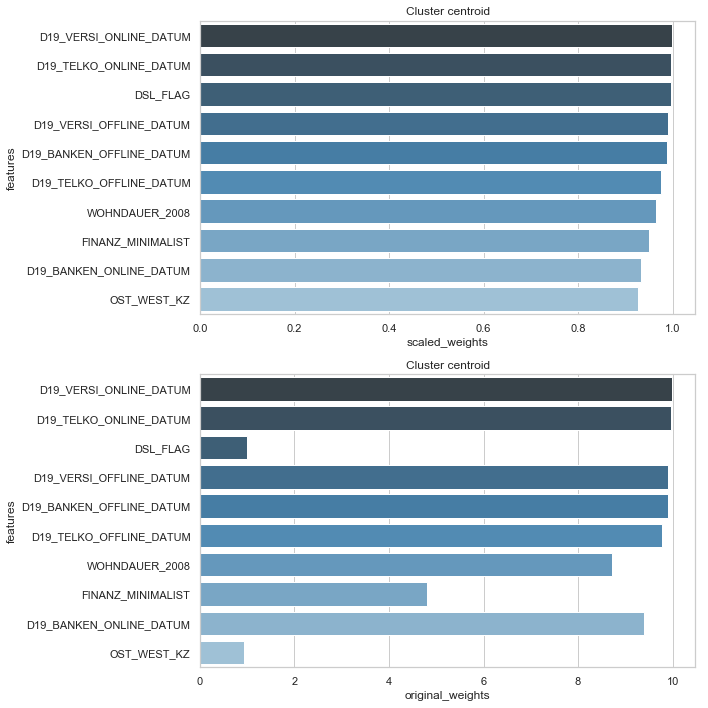

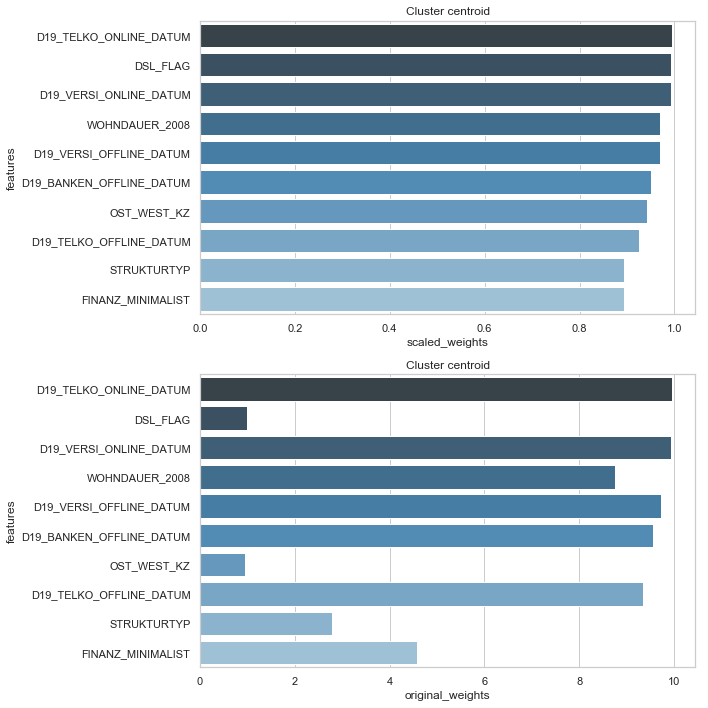

In [19]:
import seaborn as sns

# Sort the cluster based on the number of samples in the cluster
sorted_cluster = sorted([(len(cluster_group[k]), k, len(cluster_group[k])/float(pred.shape[0])) for k in cluster_group], reverse=True)
#print(sorted_cluster[:10])
#print("\n".join(["{}\t{}\t{:.3f}".format(v[1],v[0],100.0*v[2]) for v in sorted_cluster[:10]]))
#print(sum([v[2] for v in sorted_cluster[:5]]))

# The top-1 cluster is the following ID
centroid_id = sorted_cluster[0][1]
print(centroid_id)


# Display the component of each cluster center
def display_component(centroid_id, max_azdias, min_azdias, n_weights = 10):
    
    centroid = kmeans.cluster_centers_[centroid_id]
    
    # Create data frame of centroid features vs columns names
    comp = pd.DataFrame(list(zip(centroid, list(azdias.columns))), columns=['scaled_weights', 'features'])
    
    # Append into data frame, the absolute weights of each centroid feature 
    comp['abs_weights'] = comp['scaled_weights'].apply(lambda x: np.abs(x))

    # Append into data frame, the original weights of each centroid feature 
    comp['original_weights'] = comp.apply(lambda row: (row.scaled_weights*(max_azdias[row.features] - min_azdias[row.features]) + min_azdias[row.features]), axis = 1) 

    # Sort and copy the first 10 features
    sorted_weight_data = comp.sort_values('abs_weights', ascending=False).head(n_weights)
    
    # Output figures
    fig = plt.figure(figsize=(10,10))
    sns.set(style="whitegrid")

    # output weights after normalization
    ax=fig.add_subplot(2,1,1)
    ax=sns.barplot(data=sorted_weight_data, 
                   x="scaled_weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("Cluster centroid")

    # output weights before normalization (original)
    ax=fig.add_subplot(2,1,2)
    ax=sns.barplot(data=sorted_weight_data, 
                   x="original_weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("Cluster centroid")
    plt.tight_layout()
    plt.savefig("cluster_{}.png".format(centroid_id))
    plt.show()

# Output the top-1 centroid
display_component(centroid_id, max_azdias, min_azdias)

# Output the 2nd populous centroid
display_component(sorted_cluster[1][1], max_azdias, min_azdias)



In [20]:
# Figure out the union set of 10 most significant weights in the top-5 populous clusters
feature_set = set()
for num, cen_id, percentage in sorted_cluster[:5]:
    centroid = kmeans.cluster_centers_[cen_id]
    comp = pd.DataFrame(list(zip(centroid, list(azdias.columns))), columns=['scaled_weights', 'features'])
    comp['abs_weights'] = comp['scaled_weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comp.sort_values('abs_weights', ascending=False).head(10)
    feature_set = feature_set | set(sorted_weight_data["features"])

# Convert set to list
feature_list = list(feature_set)

# Print out the feature list
print("The most significant weights in the top-5 populous clusters are:")
print("\n".join(feature_list))
print("\n")

# Print out the corresponding weights in the features of each cluster centroids
for i in range(5):
    num, cen_id, percentage = sorted_cluster[i]

    centroid = kmeans.cluster_centers_[cen_id]
    comp = pd.DataFrame(list(zip(centroid, list(azdias.columns))), columns=['scaled_weights', 'features'])
    comp['abs_weights'] = comp['scaled_weights'].apply(lambda x: np.abs(x))
    comp['original_weights'] = comp.apply(lambda row: (row.scaled_weights*(max_azdias[row.features] - min_azdias[row.features]) + min_azdias[row.features]), axis = 1) 

    # Convert the weights to string with tab separated.
    ss = ["Cluster - " + str(cen_id), str(num), "{:.2f}".format(100*percentage)]
    for j, fr in enumerate(feature_list):
        orig_w = comp[comp['features']==fr]['original_weights']
        orig_w = np.int(np.round(orig_w))
        ss.append(str(orig_w))
    print("\t".join(ss))


The most significant weights in the top-5 populous clusters are:
RT_SCHNAEPPCHEN
D19_TELKO_ONLINE_DATUM
D19_VERSI_OFFLINE_DATUM
D19_LETZTER_KAUF_BRANCHE_nan
CJT_TYP_6
FINANZ_MINIMALIST
DSL_FLAG
CJT_TYP_4
UMFELD_JUNG
D19_BANKEN_ONLINE_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
OST_WEST_KZ
D19_TELKO_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_TELKO_OFFLINE_DATUM
STRUKTURTYP
WOHNDAUER_2008
D19_VERSI_DATUM
D19_GESAMT_DATUM
D19_BANKEN_DATUM


Cluster - 118	22950	11.97	5	10	10	0	4	5	1	4	4	9	8	10	1	9	10	10	3	9	9	5	9
Cluster - 19	14275	7.45	4	10	10	0	4	5	1	4	4	8	7	10	1	8	10	9	3	9	8	2	8
Cluster - 160	11027	5.75	3	10	10	0	4	5	1	4	4	9	7	10	1	9	10	9	2	9	8	3	8
Cluster - 83	10006	5.22	4	10	10	0	4	4	1	5	4	10	9	10	1	10	10	10	3	8	9	7	10
Cluster - 124	9867	5.15	5	10	10	1	5	3	1	5	4	10	10	10	1	10	10	10	3	8	10	10	10


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [101]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

### 1. Data cleaning - handling `NaN`, time stamps, categorical data 

In [102]:
# Fill uknown and out-of-range values with NaN
fill_unknown_values(mailout_train)

# Convert strings to integers
convert_str_to_int(mailout_train, "CAMEO_DEUG_2015")
convert_str_to_int(mailout_train, "CAMEO_INTL_2015")

# Convert 2-class data to 0,1
convert_biclass_to_int(mailout_train, "OST_WEST_KZ")

# Convert categorical data to one-hot encoding
try:
    mailout_train = convert_categories_to_onehot(mailout_train, "CAMEO_DEU_2015")
    mailout_train = convert_categories_to_onehot(mailout_train, "D19_LETZTER_KAUF_BRANCHE")
except Exception as e:
    print(e)

# Convert time stamps to days after 1900-01-01
mailout_train['EINGEFUEGT_AM'] = pd.to_datetime(mailout_train['EINGEFUEGT_AM']).sub(pd.Timestamp('1900-01-01')).dt.days

# Double check the values in each column
for column_name in mailout_train.columns:
    
    keys = mailout_train.groupby(column_name).groups.keys() 
    
    # Skip the columns with intergers of 0~49
    if set(keys) <= set(range(50)):
        continue

    print(column_name)
    print(keys)

LNR
[1, 5, 9, 10, 11, 12, 13, 14, 19, 21, 24, 26, 27, 38, 39, 46, 48, 50, 53, 56, 58, 60, 61, 62, 63, 64, 66, 69, 70, 71, 78, 79, 82, 83, 85, 90, 91, 92, 94, 95, 97, 98, 99, 106, 107, 111, 112, 114, 118, 123, 124, 126, 127, 128, 129, 130, 132, 133, 136, 138, 139, 143, 144, 145, 146, 147, 149, 150, 151, 152, 156, 157, 159, 162, 163, 166, 167, 168, 171, 173, 177, 178, 186, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 207, 208, 211, 214, 215, 216, 217, 218, 221, 222, 224, 227, 228, 229, 231, 232, 233, 234, 236, 237, 239, 240, 241, 244, 247, 248, 249, 250, 251, 253, 255, 258, 261, 264, 265, 266, 267, 271, 272, 273, 274, 275, 279, 280, 281, 289, 292, 294, 295, 300, 301, 302, 304, 305, 306, 308, 311, 312, 313, 317, 319, 323, 326, 327, 328, 329, 330, 331, 332, 335, 336, 337, 340, 342, 344, 348, 349, 350, 351, 352, 353, 355, 358, 359, 363, 364, 365, 369, 370, 371, 373, 375, 377, 378, 382, 385, 386, 387, 390, 391, 394, 395, 402, 403, 405, 406, 408, 409, 410, 411, 413, 415, 420, 422, 423, 4

EINGEFUEGT_AM
[40966.0, 41010.0, 41020.0, 41030.0, 41051.0, 41063.0, 41064.0, 41085.0, 41118.0, 41121.0, 41126.0, 41143.0, 41155.0, 41156.0, 41175.0, 41191.0, 41197.0, 41211.0, 41224.0, 41227.0, 41232.0, 41233.0, 41245.0, 41274.0, 41275.0, 41296.0, 41308.0, 41315.0, 41316.0, 41339.0, 41387.0, 41391.0, 41476.0, 41490.0, 41493.0, 41506.0, 41534.0, 41552.0, 41560.0, 41573.0, 41581.0, 41604.0, 41605.0, 41609.0, 41636.0, 41640.0, 41658.0, 33478.0, 41671.0, 41692.0, 41694.0, 41714.0, 41729.0, 41755.0, 41764.0, 41771.0, 41773.0, 41780.0, 41791.0, 41813.0, 41819.0, 33642.0, 33644.0, 33651.0, 33653.0, 41847.0, 41856.0, 41868.0, 41888.0, 41906.0, 41912.0, 41945.0, 42017.0, 42030.0, 42059.0, 42064.0, 42088.0, 42116.0, 33950.0, 33954.0, 42149.0, 33958.0, 33959.0, 42155.0, 33964.0, 33966.0, 33974.0, 33975.0, 42169.0, 42175.0, 33986.0, 33987.0, 33989.0, 33992.0, 33995.0, 33996.0, 33999.0, 34000.0, 34001.0, 34010.0, 34017.0, 34020.0, 34022.0, 34027.0, 34028.0, 42228.0, 34042.0, 34046.0, 34048.0, 3404

KBA13_ANZAHL_PKW
[0.0, 2.0, 4.0, 15.0, 25.0, 26.0, 27.0, 31.0, 32.0, 33.0, 34.0, 37.0, 38.0, 39.0, 40.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 50.0, 51.0, 52.0, 55.0, 56.0, 57.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.

MIN_GEBAEUDEJAHR
[1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0]


In [103]:
# Replace the NaN with means
for c in mailout_train.columns:
    mailout_train[c].fillna(mailout_train[c].mean(), inplace=True)

# Double check if there is still NaN value. The output should empty list.
print([col for col in mailout_train.columns if np.sum(mailout_train[col].isna()) > 0])

# Save data frame to local file
mailout_train.to_pickle("mailout_train.pkl")

[]


### 2. Normalization with min-max

In [104]:
# Read data frame from local file
mailout_train = pd.read_pickle("mailout_train.pkl")

# Apply normalization
max_mailout_train = mailout_train.max()
min_mailout_train = mailout_train.min()
normalized_mailout_train = (mailout_train - min_mailout_train)/(max_mailout_train - min_mailout_train)
normalized_mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_nan
count,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,...,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,0.498894,0.550529,0.065655,0.489788,0.662884,0.675621,0.721264,0.682927,0.394202,0.015311,...,0.008892,0.012662,0.012546,0.002700,0.239188,0.018900,0.061962,0.053280,0.007239,0.176528
std,0.288812,0.178180,0.199250,0.265116,0.052757,0.031264,0.013830,0.007717,0.157465,0.031306,...,0.093876,0.111814,0.111305,0.051893,0.426593,0.136175,0.241089,0.224593,0.084775,0.381273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.248074,0.550529,0.000000,0.380952,0.662884,0.675621,0.721264,0.682927,0.360000,0.002283,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.497809,0.550529,0.000000,0.489788,0.662884,0.675621,0.721264,0.682927,0.394202,0.006849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.749930,0.666667,0.065655,0.619048,0.662884,0.675621,0.721264,0.682927,0.480000,0.015311,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Principle Component Analysis
The PCA shows that the 60% of features hold 90% of energy, but no significat cutting points in dimension. Here the dimensions are kept for easier interpretation of decision tree.

Text(0,0.5,'Cumulative Power Ratio')

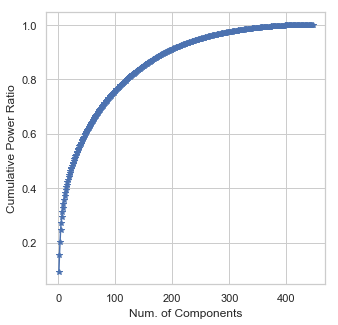

In [105]:

mailout_rotated = pca.fit_transform(normalized_mailout_train)
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")
plt.xlabel("Num. of Components")
plt.ylabel("Cumulative Power Ratio")

### 4. Supervise Learning - XGBoost

#### Load training data into XGBoost data structure

In [106]:
import os
# Need to add this env variable so the XGBoost can be executed.
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.cross_validation import  train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

seed = 999
# Separate input (Features) and output (REPONSE)
X = normalized_mailout_train.loc[:,normalized_mailout_train.columns != 'RESPONSE']
y = normalized_mailout_train["RESPONSE"]

# Split into training dataset and test dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=seed)
train_matrix = xgb.DMatrix(Xtrain, ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [156]:
# Parameters for XGBoost.

params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 500
params["early_stopping_rounds"] = 100
# params['min_child_weight'] = 2
params['max_depth'] = 5
params['eta'] = 0.02
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

# Cross validation of XGBoost to find the best iteration.
cv_results = xgb.cv(params, train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-auc:0.600232+0.121492	test-auc:0.591688+0.112747
[1]	train-auc:0.601137+0.122585	test-auc:0.591263+0.11218
[2]	train-auc:0.699628+0.0998538	test-auc:0.694259+0.0986326
[3]	train-auc:0.699827+0.0999468	test-auc:0.694259+0.0986326
[4]	train-auc:0.752193+0.00607031	test-auc:0.738354+0.0172073
[5]	train-auc:0.75083+0.0041133	test-auc:0.738458+0.0176898
[6]	train-auc:0.765242+0.0140889	test-auc:0.748957+0.0221995
[7]	train-auc:0.767839+0.0129302	test-auc:0.750111+0.0208966
[8]	train-auc:0.769194+0.0140046	test-auc:0.751044+0.0218236
[9]	train-auc:0.780132+0.00803235	test-auc:0.75936+0.0200326
[10]	train-auc:0.780547+0.0115115	test-auc:0.754955+0.0252202
[11]	train-auc:0.781775+0.0102163	test-auc:0.758018+0.0218067
[12]	train-auc:0.780398+0.0104604	test-auc:0.75269+0.0178022
[13]	train-auc:0.782573+0.0125668	test-auc:0.754913+0.0198488
[14]	train-auc:0.784226+0.0136993	test-auc:0.754147+0.019946
[15]	train-auc:0.786348+0.014292	test-auc:0.753323+0.019566
[16]	train-auc:0.794537+0.0

[132]	train-auc:0.882597+0.00472644	test-auc:0.772941+0.025316
[133]	train-auc:0.883709+0.00478394	test-auc:0.773138+0.0254348
[134]	train-auc:0.884431+0.00494996	test-auc:0.772887+0.0252109
[135]	train-auc:0.884707+0.00516321	test-auc:0.773052+0.0250549
[136]	train-auc:0.884959+0.00473987	test-auc:0.773066+0.025174
[137]	train-auc:0.885844+0.00467784	test-auc:0.773148+0.0247688
[138]	train-auc:0.886644+0.00478566	test-auc:0.772571+0.0248516
[139]	train-auc:0.886881+0.00495432	test-auc:0.772376+0.0246936
[140]	train-auc:0.887103+0.00470213	test-auc:0.772368+0.0244408
[141]	train-auc:0.887758+0.00457133	test-auc:0.772481+0.0249777
[142]	train-auc:0.888257+0.00442903	test-auc:0.7719+0.0247193
[143]	train-auc:0.888613+0.00461096	test-auc:0.772233+0.024277
[144]	train-auc:0.889155+0.00483887	test-auc:0.773173+0.0232402
[145]	train-auc:0.8897+0.00479166	test-auc:0.773448+0.0228418
[146]	train-auc:0.89027+0.00438222	test-auc:0.773529+0.0228665
[147]	train-auc:0.890603+0.00431778	test-auc:0.7

[261]	train-auc:0.936768+0.00312816	test-auc:0.772517+0.0184355
[262]	train-auc:0.937029+0.00320988	test-auc:0.772352+0.0182868
[263]	train-auc:0.937306+0.00318729	test-auc:0.772444+0.0183301
[264]	train-auc:0.937604+0.00320801	test-auc:0.772055+0.0182497
[265]	train-auc:0.937844+0.00314926	test-auc:0.772225+0.0178083
[266]	train-auc:0.93815+0.00316927	test-auc:0.772544+0.0177186
[267]	train-auc:0.93856+0.003244	test-auc:0.772737+0.0176923
[268]	train-auc:0.938809+0.00336297	test-auc:0.773153+0.0174874
[269]	train-auc:0.939138+0.00337603	test-auc:0.773479+0.0171391
[270]	train-auc:0.939415+0.00330519	test-auc:0.773354+0.0171725
[271]	train-auc:0.939649+0.00330303	test-auc:0.773479+0.0170786
[272]	train-auc:0.939912+0.00333218	test-auc:0.773299+0.0166552


In [157]:
# Print out cross validation results
cv_results

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.591688,0.112747,0.600232,0.121492
1,0.591263,0.112180,0.601137,0.122585
2,0.694259,0.098633,0.699628,0.099854
3,0.694259,0.098633,0.699827,0.099947
4,0.738354,0.017207,0.752193,0.006070
5,0.738458,0.017690,0.750830,0.004113
6,0.748957,0.022200,0.765242,0.014089
7,0.750111,0.020897,0.767839,0.012930
8,0.751044,0.021824,0.769194,0.014005
9,0.759360,0.020033,0.780132,0.008032


In [158]:
# Get the best iteration of decision trees
n_best_trees = cv_results.shape[0]
n_best_trees

174

In [159]:
# Re-train the XGBoost on the entire training set
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-auc:0.744563
[1]	train-auc:0.746388
[2]	train-auc:0.74617
[3]	train-auc:0.746684
[4]	train-auc:0.751804
[5]	train-auc:0.751775
[6]	train-auc:0.751833
[7]	train-auc:0.751859
[8]	train-auc:0.751823
[9]	train-auc:0.775609
[10]	train-auc:0.780823
[11]	train-auc:0.78365
[12]	train-auc:0.789083
[13]	train-auc:0.789595
[14]	train-auc:0.790981
[15]	train-auc:0.791383
[16]	train-auc:0.793159
[17]	train-auc:0.797272
[18]	train-auc:0.798898
[19]	train-auc:0.801639
[20]	train-auc:0.803774
[21]	train-auc:0.804251
[22]	train-auc:0.804763
[23]	train-auc:0.80441
[24]	train-auc:0.804062
[25]	train-auc:0.804594
[26]	train-auc:0.804367
[27]	train-auc:0.805506
[28]	train-auc:0.805409
[29]	train-auc:0.805867
[30]	train-auc:0.807929
[31]	train-auc:0.80754
[32]	train-auc:0.807949
[33]	train-auc:0.807025
[34]	train-auc:0.80686
[35]	train-auc:0.809095
[36]	train-auc:0.808986
[37]	train-auc:0.80968
[38]	train-auc:0.811312
[39]	train-auc:0.814986
[40]	train-auc:0.814802
[41]	train-auc:0.815143
[42]	tra

#### Output the ROC curve and calculate the ROC-AUC

(30073, 445)
30073
auc = 0.891921358356


Text(0,0.5,'TPR')

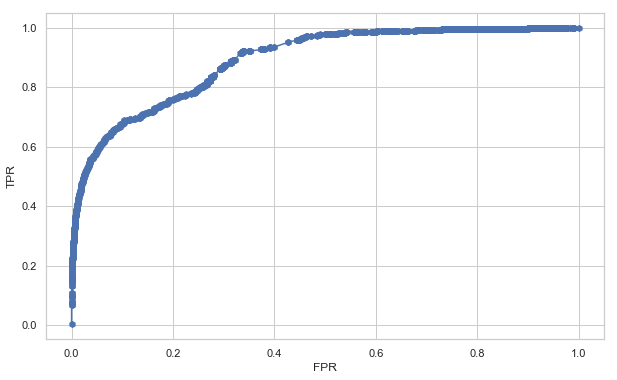

In [160]:
from sklearn.metrics import roc_curve, auc

# Plotting function
def plot_validation_roc():
    #Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.99,random_state=seed)
    print(Xtrain.shape)
    valid_matrix = xgb.DMatrix(Xtrain)

    temp_gbt = gbt
    yvalid_proba_pred = gbt.predict(valid_matrix,ntree_limit=n_best_trees)
    print(len(yvalid_proba_pred))
    fpr,tpr,thresholds = roc_curve(ytrain,yvalid_proba_pred)
    print("auc = {}".format(auc(fpr,tpr)))
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

roc = plot_validation_roc()
plt.figure(figsize=(10,6))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [161]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

### 1. Data cleaning - handle `NaN`, time stamp, and categorical data

In [162]:
# Replace unknown values with Nan
fill_unknown_values(mailout_test)

# Handle string
convert_str_to_int(mailout_test, "CAMEO_DEUG_2015")
convert_str_to_int(mailout_test, "CAMEO_INTL_2015")

convert_biclass_to_int(mailout_test, "OST_WEST_KZ")

# Handle categorical data
mailout_test = convert_categories_to_onehot(mailout_test, "CAMEO_DEU_2015")
mailout_test = convert_categories_to_onehot(mailout_test, "D19_LETZTER_KAUF_BRANCHE")


# Handle time stamps
mailout_test['EINGEFUEGT_AM'] = pd.to_datetime(mailout_test['EINGEFUEGT_AM']).sub(pd.Timestamp('1900-01-01')).dt.days

# Replace NaN with means
for c in mailout_test.columns:
    mailout_test[c].fillna(mailout_test[c].mean(), inplace=True)
print([col for col in mailout_test.columns if np.sum(mailout_test[col].isna()) > 0])

# Normalization with min-max
max_mailout_test = mailout_test.max()
min_mailout_test = mailout_test.min()
normalized_mailout_test = (mailout_test - min_mailout_test)/(max_mailout_test - min_mailout_test)

# Check the min-max of each columns. The min, max should be 0 and 1
normalized_mailout_test.describe()

[]


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_nan
count,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,...,42833.000000,42833.000000,42833.000000,42833.000000,42833.00000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000
mean,0.501109,0.550505,0.064861,0.487596,0.658377,0.710161,0.703566,0.601140,0.392903,0.017810,...,0.009409,0.012280,0.012467,0.002802,0.23615,0.020592,0.060141,0.054047,0.006841,0.175706
std,0.288554,0.179112,0.198950,0.266515,0.054131,0.029916,0.015871,0.007544,0.158840,0.035498,...,0.096542,0.110135,0.110959,0.052856,0.42472,0.142014,0.237750,0.226113,0.082425,0.380574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.252331,0.550505,0.000000,0.380952,0.658377,0.710161,0.703566,0.601140,0.360000,0.002639,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.501818,0.550505,0.000000,0.487596,0.658377,0.710161,0.703566,0.601140,0.392903,0.007916,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750070,0.666667,0.064861,0.619048,0.658377,0.710161,0.703566,0.601140,0.480000,0.017810,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [163]:
print(normalized_mailout_test.shape)

# Load test data frame into XGBoost data structure
test_matrix = xgb.DMatrix(normalized_mailout_test)

# Prediction of test data
pred = gbt.predict(test_matrix, ntree_limit=n_best_trees)
print(len(pred))

# Create data frame from test data
df_pred_test = pd.DataFrame({"RESPONSE":pred})

(42833, 445)
42833


In [164]:
# Save the data frame to the Kaggle-competition CSV format. (two columns of LNR and RESPONSE)
mailout_test_save = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
df = pd.DataFrame({"LNR":mailout_test_save["LNR"], "RESPONSE":pred})
print(df.columns)
df.to_csv("test_pred.csv",index=False)

Index([u'LNR', u'RESPONSE'], dtype='object')


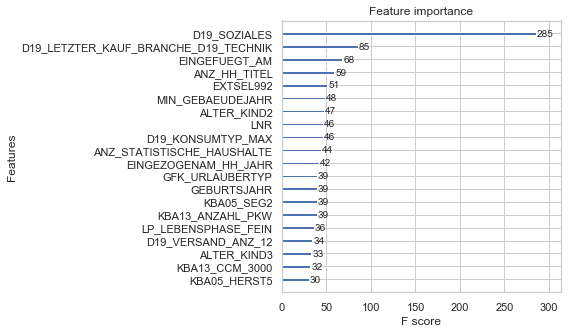

In [165]:
xgb.plot_importance(gbt, max_num_features=20)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()